<a href="https://colab.research.google.com/github/matteo9910/StressDetectionBasedOnWearableSensorData/blob/main/CAMPANELLA_CNN_45SEC_75OL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import zipfile
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import seaborn as sns
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
import math
from scipy.stats import mannwhitneyu
from scipy.signal import welch
import ipywidgets as widgets
from IPython.display import display
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.signal import resample
from scipy.signal import find_peaks
import scipy.signal

In [ ]:
def parse_numeric_value(x):
    """Pulisce una stringa con più punti nel numero, mantenendo solo il primo come separatore decimale."""
    try:
        if isinstance(x, str):
            x = x.strip().replace(' ', '')  # Rimuove spazi
            if x.count('.') > 1:
                parts = x.split('.')
                return float(parts[0] + '.' + ''.join(parts[1:]))
            return float(x)
        return float(x)
    except:
        return np.nan

In [ ]:
def load_empatica_subjects_data(base_path, target_freq=64):
    """
    Carica, pulisce e normalizza i segnali da cartelle Empatica in un unico DataFrame.
    """
    freq_map = {
        'ACC': 32,
        'BVP': 64,
        'EDA': 4,
        'TEMP': 4
    }

    signal_files = ['ACC.csv', 'BVP.csv', 'EDA.csv', 'TEMP.csv']
    subjects = sorted([d for d in os.listdir(base_path) if d.startswith("subject_")])
    all_data = []

    for subject in subjects:
        subject_path = os.path.join(base_path, subject)
        signals = {}

        for signal_name in signal_files:
            file_path = os.path.join(subject_path, signal_name)
            try:
                # Caricamento file, parsing numerico sicuro su ogni colonna
                raw_data = pd.read_csv(file_path, header=None)
                for col in raw_data.columns:
                    raw_data[col] = raw_data[col].map(parse_numeric_value)

                # Frequenza originale
                orig_freq = freq_map[signal_name.split('.')[0]]
                n_samples = int(len(raw_data) * target_freq / orig_freq)

                # Resample
                resampled = resample(raw_data.values, n_samples, axis=0)

                if signal_name == 'ACC.csv':
                    signals['acc1'] = resampled[:, 0]
                    signals['acc2'] = resampled[:, 1]
                    signals['acc3'] = resampled[:, 2]
                else:
                    key = signal_name.split('.')[0].lower()
                    signals[key] = resampled.squeeze()

            except Exception as e:
                print(f"Errore caricando {file_path}: {e}")
                continue

        # Allineamento lunghezze
        min_len = min(len(sig) for sig in signals.values())
        for k in signals:
            signals[k] = signals[k][:min_len]

        df_subject = pd.DataFrame(signals)
        df_subject['subject'] = subject
        all_data.append(df_subject)

    return pd.concat(all_data, ignore_index=True)

In [ ]:
df = load_empatica_subjects_data('/content/drive/MyDrive/CAMPANELLA ET.AL DATASET/Subjects')
df.head()

,acc1,acc2,acc3,bvp,eda,temp,subject
0,-11.000000,-42.000000,47.000000,-5.081451e-15,6.160874e-15,32.680000,subject_01
1,-3.731070,-48.832680,53.868799,-5.371820e-14,-2.176869e-01,32.693612,subject_01
2,-12.000000,-42.000000,48.000000,-5.081451e-15,-3.885328e-01,32.704953,subject_01
3,-17.019673,-38.224616,44.537763,-2.499893e-14,-5.120843e-01,32.713979,subject_01
4,-13.000000,-42.000000,48.000000,2.958131e-14,-5.889338e-01,32.720702,subject_01


In [ ]:
def assign_labels_to_dataset(df, fs=64):
    """
    Etichetta ogni record del dataset seguendo il protocollo degli autori:
    - Primi 27 minuti: pattern misto stress/rest
    - Dal 28° minuto a -5 dalla fine: stress continuo
    - Ultimi 5 minuti: pattern fisso [0, 0, 1, 0, 0]

    Restituisce il DataFrame con una colonna 'label' assegnata.
    """
    samples_per_minute = fs * 60
    labeled_data = []

    for subject in df['subject'].unique():
        df_subj = df[df['subject'] == subject].reset_index(drop=True)
        total_samples = len(df_subj)

        # Indici di separazione
        first_end = 27 * samples_per_minute
        last_start = total_samples - 5 * samples_per_minute

        labels = np.ones(total_samples, dtype=int)  # default: stress

        # Etichettatura primi 27 minuti
        first_labels = np.ones(27, dtype=int)
        rest_minutes = [0, 1, 2, 13, 14, 20, 21, 25, 26]
        for idx in rest_minutes:
            if idx < len(first_labels):
                first_labels[idx] = 0

        for i, label in enumerate(first_labels):
            start = i * samples_per_minute
            end = min((i + 1) * samples_per_minute, total_samples)
            labels[start:end] = label

        # Etichettatura ultimi 5 minuti con pattern fisso
        final_pattern = [0, 0, 1, 0, 0]
        for i, label in enumerate(final_pattern):
            start = last_start + i * samples_per_minute
            end = min(start + samples_per_minute, total_samples)
            if start < total_samples:
                labels[start:end] = label

        df_subj['label'] = labels
        labeled_data.append(df_subj)

    return pd.concat(labeled_data, ignore_index=True)

In [ ]:
df = assign_labels_to_dataset(df)
df.head()

,acc1,acc2,acc3,bvp,eda,temp,subject,label
0,-11.000000,-42.000000,47.000000,-5.081451e-15,6.160874e-15,32.680000,subject_01,0
1,-3.731070,-48.832680,53.868799,-5.371820e-14,-2.176869e-01,32.693612,subject_01,0
2,-12.000000,-42.000000,48.000000,-5.081451e-15,-3.885328e-01,32.704953,subject_01,0
3,-17.019673,-38.224616,44.537763,-2.499893e-14,-5.120843e-01,32.713979,subject_01,0
4,-13.000000,-42.000000,48.000000,2.958131e-14,-5.889338e-01,32.720702,subject_01,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149992 entries, 0 to 4149991
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   acc1     float64
 1   acc2     float64
 2   acc3     float64
 3   bvp      float64
 4   eda      float64
 5   temp     float64
 6   subject  object 
 7   label    int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 253.3+ MB


In [ ]:
df.describe()

,acc1,acc2,acc3,bvp,eda,temp,label
count,4.149992e+06,4.149992e+06,4.149992e+06,4.149992e+06,4.149992e+06,4.149992e+06,4.149992e+06
mean,-3.535236e+01,-3.736105e+00,3.941349e+01,-2.878704e-04,1.288284e+00,3.072690e+01,6.511608e-01
std,2.346571e+01,1.922544e+01,2.465455e+01,1.064747e+02,1.666268e+00,2.317582e+00,4.766031e-01
min,-1.639683e+02,-1.454716e+02,-1.553384e+02,-2.028660e+03,-1.395154e+00,2.547305e+01,0.000000e+00
25%,-5.373538e+01,-1.230737e+01,2.692636e+01,-2.882000e+01,3.130024e-01,2.923413e+01,0.000000e+00
50%,-3.768750e+01,-2.910135e+00,4.700000e+01,1.810000e+00,6.492752e-01,3.098952e+01,1.000000e+00
75%,-2.209895e+01,6.000000e+00,5.865897e+01,3.030000e+01,1.660052e+00,3.275977e+01,1.000000e+00
max,1.646671e+02,1.324840e+02,1.695915e+02,2.627920e+03,1.319185e+01,3.447453e+01,1.000000e+00


In [ ]:
df['acc_mag'] = np.sqrt(df['acc1']**2 + df['acc2']**2 + df['acc3']**2)
df = df.drop(columns=['acc1', 'acc2', 'acc3'], axis = 1)

In [ ]:
freq_assolute = df['label'].value_counts()
freq_relative = df['label'].value_counts(normalize=True)

frequency_table = pd.DataFrame({
    'Absolute Frequency': freq_assolute,
    'Relative Frequency': freq_relative.round(2)*100
})

frequency_table

,Absolute Frequency,Relative Frequency
label,,
1,2702312,65.0
0,1447680,35.0


In [ ]:
df.isna().sum()

,0
bvp,0
eda,0
temp,0
subject,0
label,0
acc_mag,0


In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 25.2 MB/s eta 0:00:00


In [ ]:
import neurokit2 as nk

In [ ]:
ppg_raw = df["bvp"].values

fs = 64

ppg_signals, ppg_info = nk.ppg_process(ppg_raw, sampling_rate=fs)

ppg_clean = ppg_signals["PPG_Clean"]

df['bvp'] = ppg_clean

In [ ]:
eda_raw = df["eda"].values

fs = 64

eda_signals, eda_info = nk.eda_process(eda_raw, sampling_rate=fs)

eda_clean = eda_signals["EDA_Clean"]

df['eda'] = eda_clean

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def acc_denoise(acc_signal, fs):

    b_high, a_high = butter_highpass(0.5, fs)
    acc_signal = filtfilt(b_high, a_high, acc_signal)

    b_low, a_low = butter_lowpass(20.0, fs)
    acc_signal = filtfilt(b_low, a_low, acc_signal)

    return acc_signal

In [ ]:
fs = 64
df['acc_mag'] = acc_denoise(df['acc_mag'].values, fs)

In [ ]:
def temp_denoise(temp_signal, fs):
  b_low, a_low = butter_lowpass(0.5, fs)
  temp_signal = filtfilt(b_low, a_low, temp_signal)
  return temp_signal

In [ ]:
fs = 64
df['temp'] = temp_denoise(df['temp'].values, fs)

In [ ]:
df['subject'].value_counts()

,count
subject,
subject_26,169856
subject_14,165888
subject_01,160256
subject_28,160000
subject_25,160000
subject_17,153472
subject_02,150720
subject_29,149120
subject_15,145920


In [ ]:
fs = 64
win_sec = 45
overlap = 0.75
win_size = fs * win_sec
step_size = win_size // 2

In [ ]:
def create_windowed_array_per_signal(df, signal_col, fs=64, win_sec=45, overlap=0.75, threshold=0.7):
    win_size = int(fs * win_sec)
    step_size = int(win_size * (1 - overlap))

    X = []
    y = []
    groups = []

    for subject_id in df['subject'].unique():
        df_subj = df[df['subject'] == subject_id].reset_index(drop=True)
        signal = df_subj[signal_col].values.astype(np.float32)
        labels = df_subj['label'].values.astype(int)

        for start in range(0, len(signal) - win_size + 1, step_size):
            end = start + win_size
            window = signal[start:end]
            window_labels = labels[start:end]

            # Conta le occorrenze di ciascuna label nella finestra
            counts = np.bincount(window_labels, minlength=2)
            total = np.sum(counts)
            dominant_label = np.argmax(counts)
            dominant_ratio = counts[dominant_label] / total

            # Condizione: label dominante deve essere almeno il 70%
            if dominant_ratio >= threshold:
                X.append(window)
                y.append(dominant_label)
                groups.append(subject_id)

    X = np.array(X)[..., np.newaxis]  # aggiungi dimensione canale per CNN
    y = np.array(y).astype(int)
    groups = np.array(groups)

    return X, y, groups

In [ ]:
 segnali = ['bvp', 'eda', 'acc_mag', 'temp']

In [ ]:
X_dict = {}
for segnale in segnali:
    print(f"Processing {segnale}...")
    X, y_raw, groups = create_windowed_array_per_signal(
        df, signal_col=segnale, fs=fs, win_sec=win_sec, overlap=overlap, threshold=0.7
    )

    if segnale == segnali[0]:
        y = y_raw  # le label sono già 0/1, non serve sottrarre 1
        group_labels = groups

    X_dict[segnale] = X

Processing bvp...
Processing eda...
Processing acc_mag...
Processing temp...


In [ ]:
for segnale in segnali:
  print(f"Tipo: {type(X_dict[segnale])} Dimensione {segnale}: {X_dict[segnale].shape}")

Tipo: <class 'numpy.ndarray'> Dimensione bvp: (5197, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione eda: (5197, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione acc_mag: (5197, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione temp: (5197, 2880, 1)


In [ ]:
print(f"Tipo: {type(y)} Dimensione y: {y.shape}")

Tipo: <class 'numpy.ndarray'> Dimensione y: (5197,)


In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([1678, 3519]))

In [ ]:
for seg in segnali:
    print(f"{seg}: {X_dict[seg].dtype}")

bvp: float32
eda: float32
acc_mag: float32
temp: float32


In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Concatenate, Dense, ReLU, LeakyReLU
from tensorflow.keras.layers import Dropout, Concatenate, GlobalAveragePooling1D, SpatialDropout1D
from tensorflow.keras.activations import sigmoid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Add, Multiply, Reshape, Activation
from tensorflow.keras.activations import gelu
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [ ]:
def se_block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling1D()(input_tensor)
    se = Dense(filters // reduction, activation='gelu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, filters))(se)
    return Multiply()([input_tensor, se])

In [ ]:
def conv_block_1d(input_signal):
    he_init = HeNormal()

    # Primo blocco semplice
    x = Conv1D(32, kernel_size=7, strides=1, padding='same', kernel_initializer=he_init)(input_signal)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=4, strides=4)(x)
    x = SpatialDropout1D(0.3)(x)

    # Secondo blocco multi-scala
    conv3 = Conv1D(64, kernel_size=3, padding='same', kernel_initializer=he_init)(x)
    conv5 = Conv1D(64, kernel_size=5, padding='same', kernel_initializer=he_init)(x)
    conv7 = Conv1D(64, kernel_size=7, padding='same', kernel_initializer=he_init)(x)
    x = Concatenate()([conv3, conv5, conv7])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = SpatialDropout1D(0.3)(x)

    # Terzo blocco con residual
    shortcut = x
    y = Conv1D(128, kernel_size=3, padding='same', kernel_initializer=he_init)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPooling1D(pool_size=2, strides=2)(y)
    shortcut = Conv1D(128, kernel_size=1, strides=2, padding='same', kernel_initializer=he_init)(shortcut)
    x = Add()([shortcut, y])
    x = SpatialDropout1D(0.3)(x)

    # Quarto blocco + SE + GAP/GMP
    x = Conv1D(256, kernel_size=3, padding='same', kernel_initializer=he_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x)

    # Quinto blocco aggiuntivo (nuovo)
    x = Conv1D(256, kernel_size=1, padding='same', kernel_initializer=he_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(0.3)(x)

    # Pooling globale misto
    gap = GlobalAveragePooling1D()(x)
    gmp = GlobalMaxPooling1D()(x)
    x = Concatenate()([gap, gmp])

    return x

In [ ]:
def build_cnn_model(input_shape=(2880, 1), n_signals=4):
    """
    CNN semplificata con migliore regolarizzazione
    """
    from tensorflow.keras.regularizers import l2

    he_init = HeNormal()
    inputs = []
    conv_outputs = []

    for _ in range(n_signals):
        inp = Input(shape=input_shape)

        # SEMPLIFICATO: Primo blocco
        x = Conv1D(32, kernel_size=7, strides=1, padding='same',
                  kernel_initializer=he_init, kernel_regularizer=l2(0.001))(inp)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=4, strides=4)(x)
        x = SpatialDropout1D(0.2)(x)

        # SEMPLIFICATO: Secondo blocco
        x = Conv1D(64, kernel_size=5, padding='same',
                  kernel_initializer=he_init, kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        x = SpatialDropout1D(0.3)(x)

        # SEMPLIFICATO: Terzo blocco
        x = Conv1D(128, kernel_size=3, padding='same',
                  kernel_initializer=he_init, kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        x = SpatialDropout1D(0.3)(x)

        # SEMPLIFICATO: Solo Global Average Pooling
        x = GlobalAveragePooling1D()(x)

        inputs.append(inp)
        conv_outputs.append(x)

    # SEMPLIFICATO: Fusione e classificazione
    x = Concatenate()(conv_outputs)
    x = Dropout(0.5)(x)

    # RIDOTTO: Meno layer fully connected
    x = Dense(64, kernel_initializer=he_init, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    x = Dense(32, kernel_initializer=he_init, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-8
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        loss = -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
               -tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

        return loss
    return focal_loss_fixed

CICLO LOSO

In [ ]:
import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
logo = LeaveOneGroupOut()

Trovati risultati esistenti per 17 soggetti: {'subject_15', 'subject_05', 'subject_02', 'subject_07', 'subject_13', 'subject_14', 'subject_09', 'subject_12', 'subject_06', 'subject_17', 'subject_04', 'subject_11', 'subject_01', 'subject_08', 'subject_16', 'subject_10', 'subject_03'}
Caricando dati globali esistenti...
Caricati 3043 campioni da esecuzioni precedenti
Caricati dettagli per 17 fold esistenti
=== INIZIO CICLO LOSO CON RACCOLTA METRICHE ===
== Fold 1 - subject_01 già completato, salto ==
== Fold 2 - subject_02 già completato, salto ==
== Fold 3 - subject_03 già completato, salto ==
== Fold 4 - subject_04 già completato, salto ==
== Fold 5 - subject_05 già completato, salto ==
== Fold 6 - subject_06 già completato, salto ==
== Fold 7 - subject_07 già completato, salto ==
== Fold 8 - subject_08 già completato, salto ==
== Fold 9 - subject_09 già completato, salto ==
== Fold 10 - subject_10 già completato, salto ==
== Fold 11 - subject_11 già completato, salto ==
== Fold 12 - s

315/315 ━━━━━━━━━━━━━━━━━━━━ 154s 445ms/step - accuracy: 0.4871 - loss: 1.8256 - val_accuracy: 0.3413 - val_loss: 1.1295 - learning_rate: 0.0010
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4532 - loss: 1.0001
Epoch 2: val_loss improved from 1.12947 to 0.62090, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold18_subject_18.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 441ms/step - accuracy: 0.4532 - loss: 0.9997 - val_accuracy: 0.3413 - val_loss: 0.6209 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4804 - loss: 0.5522
Epoch 3: val_loss improved from 0.62090 to 0.36455, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold18_subject_18.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 443ms/step - accuracy: 0.4803 - loss: 0.5520 - val_accuracy: 0.3413 - val_loss: 0.3645 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.4222 - loss: 0.3335
Epoch 4: val_loss improved from 0.36455 to 0.23583, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold18_subject_18.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 437ms/step - accuracy: 0.4222 - loss: 0.3334 - val_accuracy: 0.3413 - val_loss: 0.2358 - learning_rate: 0.0010
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4151 - loss: 0.2167
Epoch 5: val_loss improved from 0.23583 to 0.16610, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold18_subject_18.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 437ms/step - accuracy: 0.4151 - loss: 0.2167 - val_accuracy: 0.3892 - val_loss: 0.1661 - learning_rate: 0.0010
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4024 - loss: 0.1564
Epoch 6: val_loss improved from 0.16610 to 0.12905, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold18_subject_18.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 454ms/step - accuracy: 0.4024 - loss: 0.1564 - val_accuracy: 0.3413 - val_loss: 0.1290 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4052 - loss: 0.1239
Epoch 7: val_loss improved from 0.12905 to 0.11629, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold18_subject_18.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 137s 435ms/step - accuracy: 0.4052 - loss: 0.1239 - val_accuracy: 0.6587 - val_loss: 0.1163 - learning_rate: 0.0010
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4155 - loss: 0.1067
Epoch 8: val_loss improved from 0.11629 to 0.11155, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold18_subject_18.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 138s 439ms/step - accuracy: 0.4155 - loss: 0.1067 - val_accuracy: 0.6587 - val_loss: 0.1115 - learning_rate: 0.0010
Epoch 9/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4094 - loss: 0.0959
Epoch 9: val_loss improved from 0.11155 to 0.10448, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold18_subject_18.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 137s 434ms/step - accuracy: 0.4094 - loss: 0.0959 - val_accuracy: 0.6587 - val_loss: 0.1045 - learning_rate: 0.0010
Epoch 10/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.3958 - loss: 0.0876
Epoch 10: val_loss did not improve from 0.10448
315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 429ms/step - accuracy: 0.3958 - loss: 0.0876 - val_accuracy: 0.6587 - val_loss: 0.1090 - learning_rate: 0.0010
Epoch 11/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4129 - loss: 0.0866
Epoch 11: val_loss improved from 0.10448 to 0.09138, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold18_subject_18.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 433ms/step - accuracy: 0.4129 - loss: 0.0866 - val_accuracy: 0.6587 - val_loss: 0.0914 - learning_rate: 0.0010
Epoch 12/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.3866 - loss: 0.0818
Epoch 12: val_loss did not improve from 0.09138
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 428ms/step - accuracy: 0.3867 - loss: 0.0818 - val_accuracy: 0.6587 - val_loss: 0.1418 - learning_rate: 0.0010
Epoch 13/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.4279 - loss: 0.0797
Epoch 13: val_loss did not improve from 0.09138
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 427ms/step - accuracy: 0.4279 - loss: 0.0797 - val_accuracy: 0.6587 - val_loss: 0.2196 - learning_rate: 0.0010
Epoch 14/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.4223 - loss: 0.0804
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 14: val_loss did not improve from 0.09138
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 426ms/step - accuracy: 0.4223 - loss: 0.08

315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 428ms/step - accuracy: 0.4448 - loss: 0.0772 - val_accuracy: 0.3952 - val_loss: 0.0775 - learning_rate: 7.0000e-04
Epoch 16/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.4268 - loss: 0.0773
Epoch 16: val_loss did not improve from 0.07750
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 429ms/step - accuracy: 0.4268 - loss: 0.0773 - val_accuracy: 0.6587 - val_loss: 0.0847 - learning_rate: 7.0000e-04
Epoch 17/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.4505 - loss: 0.0772
Epoch 17: val_loss did not improve from 0.07750
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 431ms/step - accuracy: 0.4505 - loss: 0.0772 - val_accuracy: 0.6587 - val_loss: 0.0963 - learning_rate: 7.0000e-04
Epoch 18/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.4323 - loss: 0.0782
Epoch 18: val_loss improved from 0.07750 to 0.07719, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold18_subject_18.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 429ms/step - accuracy: 0.4323 - loss: 0.0782 - val_accuracy: 0.7605 - val_loss: 0.0772 - learning_rate: 7.0000e-04
Epoch 19/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.4316 - loss: 0.0741
Epoch 19: val_loss did not improve from 0.07719
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 425ms/step - accuracy: 0.4316 - loss: 0.0741 - val_accuracy: 0.6587 - val_loss: 0.1206 - learning_rate: 7.0000e-04
Epoch 20/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.4690 - loss: 0.0760
Epoch 20: val_loss improved from 0.07719 to 0.07536, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold18_subject_18.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 137s 435ms/step - accuracy: 0.4690 - loss: 0.0760 - val_accuracy: 0.6228 - val_loss: 0.0754 - learning_rate: 7.0000e-04
Epoch 21/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.4450 - loss: 0.0753
Epoch 21: val_loss did not improve from 0.07536
315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 430ms/step - accuracy: 0.4451 - loss: 0.0753 - val_accuracy: 0.6587 - val_loss: 0.0878 - learning_rate: 7.0000e-04
Epoch 22/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.4445 - loss: 0.0764
Epoch 22: val_loss did not improve from 0.07536
315/315 ━━━━━━━━━━━━━━━━━━━━ 134s 426ms/step - accuracy: 0.4445 - loss: 0.0764 - val_accuracy: 0.6587 - val_loss: 0.0833 - learning_rate: 7.0000e-04
Epoch 23/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4478 - loss: 0.0761
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.

Epoch 23: val_loss did not improve from 0.07536
315/315 ━━━━━━━━━━━━━━━━━━━━ 144s 431ms/step - accuracy: 0.4479 

315/315 ━━━━━━━━━━━━━━━━━━━━ 158s 447ms/step - accuracy: 0.4252 - loss: 1.7495 - val_accuracy: 0.3432 - val_loss: 0.9694 - learning_rate: 0.0010
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4734 - loss: 0.8381
Epoch 2: val_loss improved from 0.96935 to 0.49659, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold19_subject_19.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 139s 440ms/step - accuracy: 0.4734 - loss: 0.8377 - val_accuracy: 0.3432 - val_loss: 0.4966 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4437 - loss: 0.4392
Epoch 3: val_loss improved from 0.49659 to 0.28001, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold19_subject_19.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 443ms/step - accuracy: 0.4436 - loss: 0.4390 - val_accuracy: 0.3432 - val_loss: 0.2800 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.4106 - loss: 0.2556
Epoch 4: val_loss improved from 0.28001 to 0.17975, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold19_subject_19.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 445ms/step - accuracy: 0.4106 - loss: 0.2555 - val_accuracy: 0.4083 - val_loss: 0.1797 - learning_rate: 0.0010
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4112 - loss: 0.1668
Epoch 5: val_loss improved from 0.17975 to 0.13227, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold19_subject_19.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 444ms/step - accuracy: 0.4112 - loss: 0.1667 - val_accuracy: 0.3432 - val_loss: 0.1323 - learning_rate: 0.0010
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4180 - loss: 0.1253
Epoch 6: val_loss improved from 0.13227 to 0.11349, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold19_subject_19.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 440ms/step - accuracy: 0.4180 - loss: 0.1253 - val_accuracy: 0.6568 - val_loss: 0.1135 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4186 - loss: 0.1034
Epoch 7: val_loss did not improve from 0.11349
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 436ms/step - accuracy: 0.4186 - loss: 0.1034 - val_accuracy: 0.6568 - val_loss: 0.2570 - learning_rate: 0.0010
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4260 - loss: 0.0911
Epoch 8: val_loss improved from 0.11349 to 0.09283, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold19_subject_19.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 437ms/step - accuracy: 0.4260 - loss: 0.0911 - val_accuracy: 0.6568 - val_loss: 0.0928 - learning_rate: 0.0010
Epoch 9/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.3765 - loss: 0.0852
Epoch 9: val_loss did not improve from 0.09283
315/315 ━━━━━━━━━━━━━━━━━━━━ 138s 436ms/step - accuracy: 0.3766 - loss: 0.0852 - val_accuracy: 0.6568 - val_loss: 0.1000 - learning_rate: 0.0010
Epoch 10/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4215 - loss: 0.0822
Epoch 10: val_loss did not improve from 0.09283
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 437ms/step - accuracy: 0.4214 - loss: 0.0822 - val_accuracy: 0.6568 - val_loss: 0.1030 - learning_rate: 0.0010
Epoch 11/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4286 - loss: 0.0803
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 11: val_loss did not improve from 0.09283
315/315 ━━━━━━━━━━━━━━━━━━━━ 136s 432ms/step - accuracy: 0.4286 - loss: 0.0803

315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 433ms/step - accuracy: 0.4371 - loss: 0.0788 - val_accuracy: 0.6272 - val_loss: 0.0764 - learning_rate: 7.0000e-04
Epoch 13/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4571 - loss: 0.0755
Epoch 13: val_loss did not improve from 0.07639
315/315 ━━━━━━━━━━━━━━━━━━━━ 137s 435ms/step - accuracy: 0.4571 - loss: 0.0755 - val_accuracy: 0.6568 - val_loss: 0.2137 - learning_rate: 7.0000e-04
Epoch 14/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4262 - loss: 0.0754
Epoch 14: val_loss did not improve from 0.07639
315/315 ━━━━━━━━━━━━━━━━━━━━ 135s 429ms/step - accuracy: 0.4263 - loss: 0.0754 - val_accuracy: 0.7219 - val_loss: 0.0795 - learning_rate: 7.0000e-04
Epoch 15/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4221 - loss: 0.0765
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.

Epoch 15: val_loss did not improve from 0.07639
315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 431ms/step - accuracy: 0.4221 

315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 434ms/step - accuracy: 0.4349 - loss: 0.0763 - val_accuracy: 0.3550 - val_loss: 0.0731 - learning_rate: 4.9000e-04
Epoch 17/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.4419 - loss: 0.0753
Epoch 17: val_loss did not improve from 0.07308
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 435ms/step - accuracy: 0.4419 - loss: 0.0753 - val_accuracy: 0.6746 - val_loss: 0.0821 - learning_rate: 4.9000e-04
Epoch 18/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4500 - loss: 0.0759
Epoch 18: val_loss did not improve from 0.07308
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 434ms/step - accuracy: 0.4500 - loss: 0.0759 - val_accuracy: 0.6509 - val_loss: 0.0811 - learning_rate: 4.9000e-04
Epoch 19/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4679 - loss: 0.0733
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00034300000406801696.

Epoch 19: val_loss did not improve from 0.07308
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 430ms/step - accuracy: 0.4679

315/315 ━━━━━━━━━━━━━━━━━━━━ 137s 436ms/step - accuracy: 0.4753 - loss: 0.0725 - val_accuracy: 0.6331 - val_loss: 0.0697 - learning_rate: 3.4300e-04
Epoch 22/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.4848 - loss: 0.0724
Epoch 22: val_loss did not improve from 0.06970
315/315 ━━━━━━━━━━━━━━━━━━━━ 135s 429ms/step - accuracy: 0.4848 - loss: 0.0724 - val_accuracy: 0.6746 - val_loss: 0.0777 - learning_rate: 3.4300e-04
Epoch 23/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.5078 - loss: 0.0727
Epoch 23: val_loss did not improve from 0.06970
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 429ms/step - accuracy: 0.5078 - loss: 0.0727 - val_accuracy: 0.7101 - val_loss: 0.0798 - learning_rate: 3.4300e-04
Epoch 24/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4912 - loss: 0.0726
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.

Epoch 24: val_loss did not improve from 0.06970
315/315 ━━━━━━━━━━━━━━━━━━━━ 136s 433ms/step - accuracy: 0.4912

315/315 ━━━━━━━━━━━━━━━━━━━━ 155s 444ms/step - accuracy: 0.4322 - loss: 1.8763 - val_accuracy: 0.3372 - val_loss: 1.1245 - learning_rate: 0.0010
Epoch 2/50
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.4571 - loss: 0.9957
Epoch 2: val_loss improved from 1.12451 to 0.62418, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold20_subject_20.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 448ms/step - accuracy: 0.4571 - loss: 0.9949 - val_accuracy: 0.3372 - val_loss: 0.6242 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4448 - loss: 0.5571
Epoch 3: val_loss improved from 0.62418 to 0.36468, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold20_subject_20.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 449ms/step - accuracy: 0.4448 - loss: 0.5569 - val_accuracy: 0.3372 - val_loss: 0.3647 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4109 - loss: 0.3308
Epoch 4: val_loss improved from 0.36468 to 0.23112, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold20_subject_20.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 139s 440ms/step - accuracy: 0.4109 - loss: 0.3307 - val_accuracy: 0.3372 - val_loss: 0.2311 - learning_rate: 0.0010
Epoch 5/50
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4274 - loss: 0.2128
Epoch 5: val_loss improved from 0.23112 to 0.16254, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold20_subject_20.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 443ms/step - accuracy: 0.4274 - loss: 0.2126 - val_accuracy: 0.3372 - val_loss: 0.1625 - learning_rate: 0.0010
Epoch 6/50
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4080 - loss: 0.1525
Epoch 6: val_loss improved from 0.16254 to 0.12829, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold20_subject_20.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 444ms/step - accuracy: 0.4081 - loss: 0.1525 - val_accuracy: 0.6628 - val_loss: 0.1283 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4255 - loss: 0.1219
Epoch 7: val_loss did not improve from 0.12829
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 441ms/step - accuracy: 0.4255 - loss: 0.1219 - val_accuracy: 0.6628 - val_loss: 0.3607 - learning_rate: 0.0010
Epoch 8/50
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4210 - loss: 0.1064
Epoch 8: val_loss improved from 0.12829 to 0.10788, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold20_subject_20.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 438ms/step - accuracy: 0.4209 - loss: 0.1063 - val_accuracy: 0.6628 - val_loss: 0.1079 - learning_rate: 0.0010
Epoch 9/50
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4099 - loss: 0.0959
Epoch 9: val_loss improved from 0.10788 to 0.09791, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold20_subject_20.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 438ms/step - accuracy: 0.4099 - loss: 0.0959 - val_accuracy: 0.6628 - val_loss: 0.0979 - learning_rate: 0.0010
Epoch 10/50
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.3954 - loss: 0.0914
Epoch 10: val_loss did not improve from 0.09791
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 434ms/step - accuracy: 0.3954 - loss: 0.0914 - val_accuracy: 0.6628 - val_loss: 0.1002 - learning_rate: 0.0010
Epoch 11/50
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4152 - loss: 0.0833
Epoch 11: val_loss did not improve from 0.09791
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 433ms/step - accuracy: 0.4152 - loss: 0.0833 - val_accuracy: 0.6628 - val_loss: 0.1768 - learning_rate: 0.0010
Epoch 12/50
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4103 - loss: 0.0812
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 12: val_loss did not improve from 0.09791
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 432ms/step - accuracy: 0.4104 - loss: 0.08

315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 434ms/step - accuracy: 0.4271 - loss: 0.0777 - val_accuracy: 0.6628 - val_loss: 0.0827 - learning_rate: 7.0000e-04
Epoch 14/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4071 - loss: 0.0766
Epoch 14: val_loss did not improve from 0.08271
315/315 ━━━━━━━━━━━━━━━━━━━━ 138s 438ms/step - accuracy: 0.4071 - loss: 0.0766 - val_accuracy: 0.6628 - val_loss: 0.2091 - learning_rate: 7.0000e-04
Epoch 15/50
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4457 - loss: 0.0769
Epoch 15: val_loss did not improve from 0.08271
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 435ms/step - accuracy: 0.4457 - loss: 0.0769 - val_accuracy: 0.6628 - val_loss: 0.1563 - learning_rate: 7.0000e-04
Epoch 16/50
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4255 - loss: 0.0750
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.

Epoch 16: val_loss did not improve from 0.08271
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 433ms/step - accuracy: 0.4256 

315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 435ms/step - accuracy: 0.4417 - loss: 0.0750 - val_accuracy: 0.7151 - val_loss: 0.0785 - learning_rate: 4.9000e-04
Epoch 18/50
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4544 - loss: 0.0751
Epoch 18: val_loss did not improve from 0.07854
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 432ms/step - accuracy: 0.4544 - loss: 0.0751 - val_accuracy: 0.6628 - val_loss: 0.1004 - learning_rate: 4.9000e-04
Epoch 19/50
314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4303 - loss: 0.0741
Epoch 19: val_loss did not improve from 0.07854
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 431ms/step - accuracy: 0.4303 - loss: 0.0741 - val_accuracy: 0.6628 - val_loss: 0.0821 - learning_rate: 4.9000e-04
Epoch 20/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4502 - loss: 0.0741
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00034300000406801696.

Epoch 20: val_loss did not improve from 0.07854
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 431ms/step - accuracy: 0.4502


--- RISULTATI FOLD 20 - subject_20 ---
Soglia ottimale: 0.518
Accuracy: 0.7384
Precision: 0.8710
Recall: 0.7105
F1-Score: 0.7826

--- CLASSIFICATION REPORT - subject_20 ---
              precision    recall  f1-score   support

   No Stress       0.58      0.79      0.67        58
      Stress       0.87      0.71      0.78       114

    accuracy                           0.74       172
   macro avg       0.73      0.75      0.73       172
weighted avg       0.77      0.74      0.75       172


--- CONFUSION MATRIX - subject_20 ---
[[46 12]
 [33 81]]
*** NUOVO MIGLIOR MODELLO: F1=0.7826 ***
Risultati salvati per subject_20
Dati globali salvati in: /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/loso_global_data.pkl
Dettagli fold salvati in: /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/loso_fold_details.pkl

FOLD 21 - SOGGETTO: subject_21
Train distribution: {np.int64(0): np.int64(1621), np.int64(1): np.int64(3403)}
Test distribution: {

314/314 ━━━━━━━━━━━━━━━━━━━━ 151s 439ms/step - accuracy: 0.4659 - loss: 1.8071 - val_accuracy: 0.3295 - val_loss: 1.0747 - learning_rate: 0.0010
Epoch 2/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.4652 - loss: 0.9387
Epoch 2: val_loss improved from 1.07470 to 0.56728, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold21_subject_21.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 139s 444ms/step - accuracy: 0.4652 - loss: 0.9383 - val_accuracy: 0.3295 - val_loss: 0.5673 - learning_rate: 0.0010
Epoch 3/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4321 - loss: 0.5021
Epoch 3: val_loss improved from 0.56728 to 0.32330, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold21_subject_21.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 143s 447ms/step - accuracy: 0.4321 - loss: 0.5019 - val_accuracy: 0.3295 - val_loss: 0.3233 - learning_rate: 0.0010
Epoch 4/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.4402 - loss: 0.2927
Epoch 4: val_loss improved from 0.32330 to 0.20515, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold21_subject_21.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 139s 437ms/step - accuracy: 0.4402 - loss: 0.2926 - val_accuracy: 0.3295 - val_loss: 0.2051 - learning_rate: 0.0010
Epoch 5/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4072 - loss: 0.1915
Epoch 5: val_loss improved from 0.20515 to 0.14653, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold21_subject_21.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 142s 437ms/step - accuracy: 0.4073 - loss: 0.1915 - val_accuracy: 0.3295 - val_loss: 0.1465 - learning_rate: 0.0010
Epoch 6/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4074 - loss: 0.1405
Epoch 6: val_loss improved from 0.14653 to 0.11599, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold21_subject_21.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 142s 436ms/step - accuracy: 0.4074 - loss: 0.1404 - val_accuracy: 0.3468 - val_loss: 0.1160 - learning_rate: 0.0010
Epoch 7/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4157 - loss: 0.1145
Epoch 7: val_loss improved from 0.11599 to 0.10999, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold21_subject_21.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 141s 434ms/step - accuracy: 0.4157 - loss: 0.1145 - val_accuracy: 0.6705 - val_loss: 0.1100 - learning_rate: 0.0010
Epoch 8/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4236 - loss: 0.1014
Epoch 8: val_loss improved from 0.10999 to 0.10513, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold21_subject_21.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 138s 440ms/step - accuracy: 0.4236 - loss: 0.1014 - val_accuracy: 0.6705 - val_loss: 0.1051 - learning_rate: 0.0010
Epoch 9/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4199 - loss: 0.0905
Epoch 9: val_loss did not improve from 0.10513
314/314 ━━━━━━━━━━━━━━━━━━━━ 141s 436ms/step - accuracy: 0.4199 - loss: 0.0905 - val_accuracy: 0.6705 - val_loss: 0.1064 - learning_rate: 0.0010
Epoch 10/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.3873 - loss: 0.0852
Epoch 10: val_loss did not improve from 0.10513
314/314 ━━━━━━━━━━━━━━━━━━━━ 139s 429ms/step - accuracy: 0.3873 - loss: 0.0852 - val_accuracy: 0.6705 - val_loss: 0.1885 - learning_rate: 0.0010
Epoch 11/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.3966 - loss: 0.0832
Epoch 11: val_loss improved from 0.10513 to 0.08292, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold21_subject_21.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 137s 437ms/step - accuracy: 0.3967 - loss: 0.0832 - val_accuracy: 0.6705 - val_loss: 0.0829 - learning_rate: 0.0010
Epoch 12/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.4250 - loss: 0.0793
Epoch 12: val_loss improved from 0.08292 to 0.07980, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold21_subject_21.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 136s 432ms/step - accuracy: 0.4249 - loss: 0.0793 - val_accuracy: 0.6821 - val_loss: 0.0798 - learning_rate: 0.0010
Epoch 13/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4040 - loss: 0.0786
Epoch 13: val_loss did not improve from 0.07980
314/314 ━━━━━━━━━━━━━━━━━━━━ 137s 437ms/step - accuracy: 0.4040 - loss: 0.0786 - val_accuracy: 0.6705 - val_loss: 0.1007 - learning_rate: 0.0010
Epoch 14/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4055 - loss: 0.0781
Epoch 14: val_loss did not improve from 0.07980
314/314 ━━━━━━━━━━━━━━━━━━━━ 139s 429ms/step - accuracy: 0.4055 - loss: 0.0781 - val_accuracy: 0.6705 - val_loss: 0.1798 - learning_rate: 0.0010
Epoch 15/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4061 - loss: 0.0786
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 15: val_loss did not improve from 0.07980
314/314 ━━━━━━━━━━━━━━━━━━━━ 142s 431ms/step - accuracy: 0.4061 - loss: 0.07

314/314 ━━━━━━━━━━━━━━━━━━━━ 142s 431ms/step - accuracy: 0.4312 - loss: 0.0756 - val_accuracy: 0.5780 - val_loss: 0.0765 - learning_rate: 7.0000e-04
Epoch 17/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.4307 - loss: 0.0761
Epoch 17: val_loss did not improve from 0.07654
314/314 ━━━━━━━━━━━━━━━━━━━━ 141s 429ms/step - accuracy: 0.4307 - loss: 0.0761 - val_accuracy: 0.6705 - val_loss: 0.0792 - learning_rate: 7.0000e-04
Epoch 18/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.4216 - loss: 0.0772
Epoch 18: val_loss did not improve from 0.07654
314/314 ━━━━━━━━━━━━━━━━━━━━ 142s 430ms/step - accuracy: 0.4216 - loss: 0.0772 - val_accuracy: 0.6705 - val_loss: 0.0852 - learning_rate: 7.0000e-04
Epoch 19/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4257 - loss: 0.0764
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.

Epoch 19: val_loss did not improve from 0.07654
314/314 ━━━━━━━━━━━━━━━━━━━━ 142s 431ms/step - accuracy: 0.4258 

314/314 ━━━━━━━━━━━━━━━━━━━━ 135s 430ms/step - accuracy: 0.4617 - loss: 0.0733 - val_accuracy: 0.3295 - val_loss: 0.0759 - learning_rate: 4.9000e-04
Predizione e valutazione...



--- RISULTATI FOLD 21 - subject_21 ---
Soglia ottimale: 0.475
Accuracy: 0.6590
Precision: 0.9014
Recall: 0.5517
F1-Score: 0.6845

--- CLASSIFICATION REPORT - subject_21 ---
              precision    recall  f1-score   support

   No Stress       0.49      0.88      0.63        57
      Stress       0.90      0.55      0.68       116

    accuracy                           0.66       173
   macro avg       0.70      0.71      0.66       173
weighted avg       0.77      0.66      0.67       173


--- CONFUSION MATRIX - subject_21 ---
[[50  7]
 [52 64]]
Risultati salvati per subject_21
Dati globali salvati in: /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/loso_global_data.pkl
Dettagli fold salvati in: /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/loso_fold_details.pkl

FOLD 22 - SOGGETTO: subject_22
Train distribution: {np.int64(0): np.int64(1620), np.int64(1): np.int64(3410)}
Test distribution: {np.int64(0): np.int64(58), np.int64(1): n

315/315 ━━━━━━━━━━━━━━━━━━━━ 156s 448ms/step - accuracy: 0.4577 - loss: 1.7732 - val_accuracy: 0.3473 - val_loss: 1.0256 - learning_rate: 0.0010
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.4690 - loss: 0.8898
Epoch 2: val_loss improved from 1.02557 to 0.53325, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold22_subject_22.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 448ms/step - accuracy: 0.4690 - loss: 0.8894 - val_accuracy: 0.3473 - val_loss: 0.5332 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4501 - loss: 0.4676
Epoch 3: val_loss improved from 0.53325 to 0.30200, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold22_subject_22.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 453ms/step - accuracy: 0.4501 - loss: 0.4674 - val_accuracy: 0.3473 - val_loss: 0.3020 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.4298 - loss: 0.2722
Epoch 4: val_loss improved from 0.30200 to 0.19413, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold22_subject_22.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 445ms/step - accuracy: 0.4298 - loss: 0.2721 - val_accuracy: 0.3473 - val_loss: 0.1941 - learning_rate: 0.0010
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4053 - loss: 0.1804
Epoch 5: val_loss improved from 0.19413 to 0.14309, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold22_subject_22.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 444ms/step - accuracy: 0.4053 - loss: 0.1803 - val_accuracy: 0.3473 - val_loss: 0.1431 - learning_rate: 0.0010
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4103 - loss: 0.1348
Epoch 6: val_loss improved from 0.14309 to 0.11728, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold22_subject_22.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 442ms/step - accuracy: 0.4103 - loss: 0.1348 - val_accuracy: 0.6527 - val_loss: 0.1173 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.3836 - loss: 0.1111
Epoch 7: val_loss improved from 0.11728 to 0.09850, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold22_subject_22.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 441ms/step - accuracy: 0.3836 - loss: 0.1111 - val_accuracy: 0.3473 - val_loss: 0.0985 - learning_rate: 0.0010
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.4068 - loss: 0.0994
Epoch 8: val_loss did not improve from 0.09850
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 441ms/step - accuracy: 0.4068 - loss: 0.0994 - val_accuracy: 0.6527 - val_loss: 0.2386 - learning_rate: 0.0010
Epoch 9/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.4127 - loss: 0.0946
Epoch 9: val_loss improved from 0.09850 to 0.09017, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold22_subject_22.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 445ms/step - accuracy: 0.4127 - loss: 0.0946 - val_accuracy: 0.7904 - val_loss: 0.0902 - learning_rate: 0.0010
Epoch 10/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.3728 - loss: 0.0867
Epoch 10: val_loss did not improve from 0.09017
315/315 ━━━━━━━━━━━━━━━━━━━━ 138s 434ms/step - accuracy: 0.3728 - loss: 0.0867 - val_accuracy: 0.6527 - val_loss: 0.0932 - learning_rate: 0.0010
Epoch 11/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.3942 - loss: 0.0825
Epoch 11: val_loss improved from 0.09017 to 0.07961, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold22_subject_22.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 435ms/step - accuracy: 0.3942 - loss: 0.0825 - val_accuracy: 0.3473 - val_loss: 0.0796 - learning_rate: 0.0010
Epoch 12/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.3727 - loss: 0.0797
Epoch 12: val_loss improved from 0.07961 to 0.07471, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold22_subject_22.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 435ms/step - accuracy: 0.3727 - loss: 0.0797 - val_accuracy: 0.3473 - val_loss: 0.0747 - learning_rate: 0.0010
Epoch 13/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.3983 - loss: 0.0789
Epoch 13: val_loss did not improve from 0.07471
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 433ms/step - accuracy: 0.3983 - loss: 0.0789 - val_accuracy: 0.6527 - val_loss: 0.1031 - learning_rate: 0.0010
Epoch 14/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.3685 - loss: 0.0768
Epoch 14: val_loss improved from 0.07471 to 0.07319, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold22_subject_22.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 433ms/step - accuracy: 0.3686 - loss: 0.0768 - val_accuracy: 0.3713 - val_loss: 0.0732 - learning_rate: 0.0010
Epoch 15/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4269 - loss: 0.0791
Epoch 15: val_loss did not improve from 0.07319
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 432ms/step - accuracy: 0.4269 - loss: 0.0791 - val_accuracy: 0.6527 - val_loss: 0.0992 - learning_rate: 0.0010
Epoch 16/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4211 - loss: 0.0780
Epoch 16: val_loss did not improve from 0.07319
315/315 ━━━━━━━━━━━━━━━━━━━━ 137s 436ms/step - accuracy: 0.4211 - loss: 0.0780 - val_accuracy: 0.6527 - val_loss: 0.1379 - learning_rate: 0.0010
Epoch 17/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4323 - loss: 0.0804
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 17: val_loss did not improve from 0.07319
315/315 ━━━━━━━━━━━━━━━━━━━━ 135s 429ms/step - accuracy: 0.4322 - loss: 0.08

315/315 ━━━━━━━━━━━━━━━━━━━━ 138s 438ms/step - accuracy: 0.4060 - loss: 0.0789 - val_accuracy: 0.5509 - val_loss: 0.0702 - learning_rate: 7.0000e-04
Epoch 19/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4452 - loss: 0.0770
Epoch 19: val_loss did not improve from 0.07018
315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 431ms/step - accuracy: 0.4452 - loss: 0.0770 - val_accuracy: 0.7186 - val_loss: 0.0726 - learning_rate: 7.0000e-04
Epoch 20/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4083 - loss: 0.0762
Epoch 20: val_loss did not improve from 0.07018
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 432ms/step - accuracy: 0.4083 - loss: 0.0762 - val_accuracy: 0.6647 - val_loss: 0.0798 - learning_rate: 7.0000e-04
Epoch 21/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4387 - loss: 0.0766
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.

Epoch 21: val_loss did not improve from 0.07018
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 430ms/step - accuracy: 0.4387 

315/315 ━━━━━━━━━━━━━━━━━━━━ 139s 442ms/step - accuracy: 0.4512 - loss: 0.0748 - val_accuracy: 0.9102 - val_loss: 0.0684 - learning_rate: 4.9000e-04
Epoch 23/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4420 - loss: 0.0746
Epoch 23: val_loss did not improve from 0.06837
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 440ms/step - accuracy: 0.4420 - loss: 0.0746 - val_accuracy: 0.3473 - val_loss: 0.0749 - learning_rate: 4.9000e-04
Epoch 24/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4696 - loss: 0.0724
Epoch 24: val_loss did not improve from 0.06837
315/315 ━━━━━━━━━━━━━━━━━━━━ 139s 430ms/step - accuracy: 0.4696 - loss: 0.0724 - val_accuracy: 0.7066 - val_loss: 0.0719 - learning_rate: 4.9000e-04
Epoch 25/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.4596 - loss: 0.0736
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00034300000406801696.

Epoch 25: val_loss did not improve from 0.06837
315/315 ━━━━━━━━━━━━━━━━━━━━ 137s 436ms/step - accuracy: 0.4596

315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 432ms/step - accuracy: 0.4927 - loss: 0.0732 - val_accuracy: 0.7964 - val_loss: 0.0584 - learning_rate: 3.4300e-04
Epoch 28/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4889 - loss: 0.0725
Epoch 28: val_loss did not improve from 0.05836
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 430ms/step - accuracy: 0.4889 - loss: 0.0725 - val_accuracy: 0.5030 - val_loss: 0.0654 - learning_rate: 3.4300e-04
Epoch 29/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.5043 - loss: 0.0719
Epoch 29: val_loss did not improve from 0.05836
315/315 ━━━━━━━━━━━━━━━━━━━━ 137s 436ms/step - accuracy: 0.5043 - loss: 0.0719 - val_accuracy: 0.6527 - val_loss: 0.1736 - learning_rate: 3.4300e-04
Epoch 30/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.5109 - loss: 0.0711
Epoch 30: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.

Epoch 30: val_loss did not improve from 0.05836
315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 431ms/step - accuracy: 0.5109

315/315 ━━━━━━━━━━━━━━━━━━━━ 155s 443ms/step - accuracy: 0.4890 - loss: 1.8609 - val_accuracy: 0.3537 - val_loss: 1.1601 - learning_rate: 0.0010
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.4892 - loss: 1.0204
Epoch 2: val_loss improved from 1.16011 to 0.63998, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold23_subject_23.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 446ms/step - accuracy: 0.4891 - loss: 1.0200 - val_accuracy: 0.3537 - val_loss: 0.6400 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4398 - loss: 0.5671
Epoch 3: val_loss improved from 0.63998 to 0.37138, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold23_subject_23.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 449ms/step - accuracy: 0.4398 - loss: 0.5669 - val_accuracy: 0.3537 - val_loss: 0.3714 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4291 - loss: 0.3312
Epoch 4: val_loss improved from 0.37138 to 0.23362, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold23_subject_23.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 138s 437ms/step - accuracy: 0.4291 - loss: 0.3311 - val_accuracy: 0.3537 - val_loss: 0.2336 - learning_rate: 0.0010
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4215 - loss: 0.2104
Epoch 5: val_loss improved from 0.23362 to 0.16271, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold23_subject_23.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 441ms/step - accuracy: 0.4215 - loss: 0.2104 - val_accuracy: 0.3537 - val_loss: 0.1627 - learning_rate: 0.0010
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4269 - loss: 0.1510
Epoch 6: val_loss improved from 0.16271 to 0.12727, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold23_subject_23.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 444ms/step - accuracy: 0.4269 - loss: 0.1510 - val_accuracy: 0.3537 - val_loss: 0.1273 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.4216 - loss: 0.1188
Epoch 7: val_loss improved from 0.12727 to 0.10711, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold23_subject_23.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 445ms/step - accuracy: 0.4216 - loss: 0.1188 - val_accuracy: 0.4146 - val_loss: 0.1071 - learning_rate: 0.0010
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.4120 - loss: 0.1001
Epoch 8: val_loss did not improve from 0.10711
315/315 ━━━━━━━━━━━━━━━━━━━━ 137s 435ms/step - accuracy: 0.4121 - loss: 0.1001 - val_accuracy: 0.6463 - val_loss: 0.1230 - learning_rate: 0.0010
Epoch 9/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.4078 - loss: 0.0920
Epoch 9: val_loss did not improve from 0.10711
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 435ms/step - accuracy: 0.4078 - loss: 0.0920 - val_accuracy: 0.6463 - val_loss: 0.1478 - learning_rate: 0.0010
Epoch 10/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4215 - loss: 0.0846
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 10: val_loss did not improve from 0.10711
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 436ms/step - accuracy: 0.4215 - loss: 0.0846 -

315/315 ━━━━━━━━━━━━━━━━━━━━ 139s 440ms/step - accuracy: 0.4364 - loss: 0.0816 - val_accuracy: 0.7073 - val_loss: 0.0837 - learning_rate: 7.0000e-04
Epoch 12/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4450 - loss: 0.0801
Epoch 12: val_loss improved from 0.08371 to 0.08201, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold23_subject_23.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 137s 436ms/step - accuracy: 0.4449 - loss: 0.0801 - val_accuracy: 0.6646 - val_loss: 0.0820 - learning_rate: 7.0000e-04
Epoch 13/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4378 - loss: 0.0781
Epoch 13: val_loss did not improve from 0.08201
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 432ms/step - accuracy: 0.4379 - loss: 0.0781 - val_accuracy: 0.6768 - val_loss: 0.0854 - learning_rate: 7.0000e-04
Epoch 14/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4871 - loss: 0.0773
Epoch 14: val_loss did not improve from 0.08201
315/315 ━━━━━━━━━━━━━━━━━━━━ 138s 437ms/step - accuracy: 0.4871 - loss: 0.0773 - val_accuracy: 0.6463 - val_loss: 0.1036 - learning_rate: 7.0000e-04
Epoch 15/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4686 - loss: 0.0773
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.

Epoch 15: val_loss did not improve from 0.08201
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 438ms/step - accuracy: 0.4686 

315/315 ━━━━━━━━━━━━━━━━━━━━ 136s 433ms/step - accuracy: 0.4750 - loss: 0.0766 - val_accuracy: 0.7256 - val_loss: 0.0793 - learning_rate: 4.9000e-04
Epoch 17/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4795 - loss: 0.0758
Epoch 17: val_loss improved from 0.07933 to 0.07879, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold23_subject_23.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 433ms/step - accuracy: 0.4795 - loss: 0.0758 - val_accuracy: 0.3537 - val_loss: 0.0788 - learning_rate: 4.9000e-04
Epoch 18/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.5014 - loss: 0.0746
Epoch 18: val_loss improved from 0.07879 to 0.07791, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold23_subject_23.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 138s 438ms/step - accuracy: 0.5014 - loss: 0.0746 - val_accuracy: 0.3537 - val_loss: 0.0779 - learning_rate: 4.9000e-04
Epoch 19/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4788 - loss: 0.0759
Epoch 19: val_loss did not improve from 0.07791
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 436ms/step - accuracy: 0.4788 - loss: 0.0759 - val_accuracy: 0.3537 - val_loss: 0.0782 - learning_rate: 4.9000e-04
Epoch 20/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4800 - loss: 0.0750
Epoch 20: val_loss did not improve from 0.07791
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 433ms/step - accuracy: 0.4801 - loss: 0.0750 - val_accuracy: 0.6463 - val_loss: 0.1137 - learning_rate: 4.9000e-04
Epoch 21/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4929 - loss: 0.0744
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00034300000406801696.

Epoch 21: val_loss did not improve from 0.07791
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 432ms/step - accuracy: 0.4928

315/315 ━━━━━━━━━━━━━━━━━━━━ 156s 449ms/step - accuracy: 0.4643 - loss: 1.7330 - val_accuracy: 0.3494 - val_loss: 0.9246 - learning_rate: 0.0010
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.4692 - loss: 0.7808
Epoch 2: val_loss improved from 0.92459 to 0.44291, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold24_subject_24.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 448ms/step - accuracy: 0.4691 - loss: 0.7804 - val_accuracy: 0.3494 - val_loss: 0.4429 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4206 - loss: 0.3823
Epoch 3: val_loss improved from 0.44291 to 0.24619, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold24_subject_24.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 446ms/step - accuracy: 0.4206 - loss: 0.3821 - val_accuracy: 0.3494 - val_loss: 0.2462 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.3935 - loss: 0.2213
Epoch 4: val_loss improved from 0.24619 to 0.15980, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold24_subject_24.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 139s 441ms/step - accuracy: 0.3935 - loss: 0.2212 - val_accuracy: 0.3494 - val_loss: 0.1598 - learning_rate: 0.0010
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.3931 - loss: 0.1490
Epoch 5: val_loss improved from 0.15980 to 0.11913, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold24_subject_24.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 440ms/step - accuracy: 0.3931 - loss: 0.1490 - val_accuracy: 0.4036 - val_loss: 0.1191 - learning_rate: 0.0010
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.3931 - loss: 0.1159
Epoch 6: val_loss improved from 0.11913 to 0.10032, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold24_subject_24.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 441ms/step - accuracy: 0.3931 - loss: 0.1158 - val_accuracy: 0.3554 - val_loss: 0.1003 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3998 - loss: 0.0976
Epoch 7: val_loss did not improve from 0.10032
315/315 ━━━━━━━━━━━━━━━━━━━━ 139s 441ms/step - accuracy: 0.3998 - loss: 0.0976 - val_accuracy: 0.6506 - val_loss: 0.2383 - learning_rate: 0.0010
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.3941 - loss: 0.0906
Epoch 8: val_loss did not improve from 0.10032
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 440ms/step - accuracy: 0.3941 - loss: 0.0906 - val_accuracy: 0.6506 - val_loss: 0.1064 - learning_rate: 0.0010
Epoch 9/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.3933 - loss: 0.0849
Epoch 9: val_loss improved from 0.10032 to 0.08970, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold24_subject_24.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 138s 438ms/step - accuracy: 0.3933 - loss: 0.0849 - val_accuracy: 0.6506 - val_loss: 0.0897 - learning_rate: 0.0010
Epoch 10/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.3916 - loss: 0.0818
Epoch 10: val_loss improved from 0.08970 to 0.08541, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold24_subject_24.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 436ms/step - accuracy: 0.3917 - loss: 0.0818 - val_accuracy: 0.6506 - val_loss: 0.0854 - learning_rate: 0.0010
Epoch 11/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.3815 - loss: 0.0805
Epoch 11: val_loss did not improve from 0.08541
315/315 ━━━━━━━━━━━━━━━━━━━━ 138s 439ms/step - accuracy: 0.3816 - loss: 0.0805 - val_accuracy: 0.6506 - val_loss: 0.1754 - learning_rate: 0.0010
Epoch 12/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.3991 - loss: 0.0790
Epoch 12: val_loss improved from 0.08541 to 0.07624, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold24_subject_24.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 435ms/step - accuracy: 0.3992 - loss: 0.0790 - val_accuracy: 0.4398 - val_loss: 0.0762 - learning_rate: 0.0010
Epoch 13/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4108 - loss: 0.0781
Epoch 13: val_loss did not improve from 0.07624
315/315 ━━━━━━━━━━━━━━━━━━━━ 137s 434ms/step - accuracy: 0.4108 - loss: 0.0781 - val_accuracy: 0.6506 - val_loss: 0.1080 - learning_rate: 0.0010
Epoch 14/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.3942 - loss: 0.0798
Epoch 14: val_loss did not improve from 0.07624
315/315 ━━━━━━━━━━━━━━━━━━━━ 136s 433ms/step - accuracy: 0.3942 - loss: 0.0798 - val_accuracy: 0.6506 - val_loss: 0.0810 - learning_rate: 0.0010
Epoch 15/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.3833 - loss: 0.0776
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 15: val_loss did not improve from 0.07624
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 432ms/step - accuracy: 0.3833 - loss: 0.07

313/313 ━━━━━━━━━━━━━━━━━━━━ 155s 450ms/step - accuracy: 0.4835 - loss: 1.8178 - val_accuracy: 0.2871 - val_loss: 1.0977 - learning_rate: 0.0010
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.4514 - loss: 0.9678
Epoch 2: val_loss improved from 1.09767 to 0.58713, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold25_subject_25.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 452ms/step - accuracy: 0.4514 - loss: 0.9674 - val_accuracy: 0.2871 - val_loss: 0.5871 - learning_rate: 0.0010
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.4564 - loss: 0.5200
Epoch 3: val_loss improved from 0.58713 to 0.33409, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold25_subject_25.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 452ms/step - accuracy: 0.4564 - loss: 0.5198 - val_accuracy: 0.2871 - val_loss: 0.3341 - learning_rate: 0.0010
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.4290 - loss: 0.3026
Epoch 4: val_loss improved from 0.33409 to 0.21068, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold25_subject_25.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 443ms/step - accuracy: 0.4290 - loss: 0.3025 - val_accuracy: 0.2871 - val_loss: 0.2107 - learning_rate: 0.0010
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.4125 - loss: 0.1961
Epoch 5: val_loss improved from 0.21068 to 0.14930, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold25_subject_25.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 450ms/step - accuracy: 0.4125 - loss: 0.1960 - val_accuracy: 0.2871 - val_loss: 0.1493 - learning_rate: 0.0010
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.3975 - loss: 0.1446
Epoch 6: val_loss improved from 0.14930 to 0.13111, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold25_subject_25.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 448ms/step - accuracy: 0.3976 - loss: 0.1445 - val_accuracy: 0.7129 - val_loss: 0.1311 - learning_rate: 0.0010
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4228 - loss: 0.1150
Epoch 7: val_loss improved from 0.13111 to 0.09660, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold25_subject_25.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 447ms/step - accuracy: 0.4227 - loss: 0.1150 - val_accuracy: 0.6832 - val_loss: 0.0966 - learning_rate: 0.0010
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4058 - loss: 0.1001
Epoch 8: val_loss did not improve from 0.09660
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 438ms/step - accuracy: 0.4057 - loss: 0.1001 - val_accuracy: 0.7129 - val_loss: 0.1364 - learning_rate: 0.0010
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4180 - loss: 0.0895
Epoch 9: val_loss did not improve from 0.09660
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 438ms/step - accuracy: 0.4179 - loss: 0.0895 - val_accuracy: 0.7129 - val_loss: 0.1314 - learning_rate: 0.0010
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.3959 - loss: 0.0856
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 10: val_loss did not improve from 0.09660
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 441ms/step - accuracy: 0.3959 - loss: 0.0856 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 438ms/step - accuracy: 0.3914 - loss: 0.0803 - val_accuracy: 0.5792 - val_loss: 0.0761 - learning_rate: 7.0000e-04
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4249 - loss: 0.0797
Epoch 12: val_loss did not improve from 0.07611
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 435ms/step - accuracy: 0.4249 - loss: 0.0797 - val_accuracy: 0.7129 - val_loss: 0.0800 - learning_rate: 7.0000e-04
Epoch 13/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4294 - loss: 0.0782
Epoch 13: val_loss improved from 0.07611 to 0.07277, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold25_subject_25.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 443ms/step - accuracy: 0.4294 - loss: 0.0782 - val_accuracy: 0.3960 - val_loss: 0.0728 - learning_rate: 7.0000e-04
Epoch 14/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4200 - loss: 0.0791
Epoch 14: val_loss improved from 0.07277 to 0.07214, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold25_subject_25.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 439ms/step - accuracy: 0.4200 - loss: 0.0791 - val_accuracy: 0.5000 - val_loss: 0.0721 - learning_rate: 7.0000e-04
Epoch 15/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.4078 - loss: 0.0773
Epoch 15: val_loss did not improve from 0.07214
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 439ms/step - accuracy: 0.4079 - loss: 0.0773 - val_accuracy: 0.7129 - val_loss: 0.2406 - learning_rate: 7.0000e-04
Epoch 16/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4301 - loss: 0.0777
Epoch 16: val_loss did not improve from 0.07214
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 441ms/step - accuracy: 0.4301 - loss: 0.0777 - val_accuracy: 0.7129 - val_loss: 0.1668 - learning_rate: 7.0000e-04
Epoch 17/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4515 - loss: 0.0763
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.

Epoch 17: val_loss did not improve from 0.07214
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 433ms/step - accuracy: 0.4515 

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 436ms/step - accuracy: 0.4509 - loss: 0.0762 - val_accuracy: 0.6337 - val_loss: 0.0716 - learning_rate: 4.9000e-04
Epoch 19/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.4777 - loss: 0.0743
Epoch 19: val_loss did not improve from 0.07162
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 440ms/step - accuracy: 0.4777 - loss: 0.0743 - val_accuracy: 0.7129 - val_loss: 0.0943 - learning_rate: 4.9000e-04
Epoch 20/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4608 - loss: 0.0750
Epoch 20: val_loss did not improve from 0.07162
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 433ms/step - accuracy: 0.4609 - loss: 0.0750 - val_accuracy: 0.7129 - val_loss: 0.0762 - learning_rate: 4.9000e-04
Epoch 21/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.4861 - loss: 0.0760
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00034300000406801696.

Epoch 21: val_loss did not improve from 0.07162
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 436ms/step - accuracy: 0.4861

313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 438ms/step - accuracy: 0.4811 - loss: 0.0729 - val_accuracy: 0.3663 - val_loss: 0.0704 - learning_rate: 3.4300e-04
Epoch 23/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4691 - loss: 0.0741
Epoch 23: val_loss improved from 0.07037 to 0.06649, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold25_subject_25.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 433ms/step - accuracy: 0.4691 - loss: 0.0741 - val_accuracy: 0.6584 - val_loss: 0.0665 - learning_rate: 3.4300e-04
Epoch 24/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4838 - loss: 0.0739
Epoch 24: val_loss did not improve from 0.06649
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 432ms/step - accuracy: 0.4838 - loss: 0.0739 - val_accuracy: 0.7129 - val_loss: 0.0778 - learning_rate: 3.4300e-04
Epoch 25/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4907 - loss: 0.0726
Epoch 25: val_loss did not improve from 0.06649
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 431ms/step - accuracy: 0.4907 - loss: 0.0726 - val_accuracy: 0.7327 - val_loss: 0.0731 - learning_rate: 3.4300e-04
Epoch 26/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.4850 - loss: 0.0727
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.

Epoch 26: val_loss did not improve from 0.06649
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 433ms/step - accuracy: 0.4850

312/312 ━━━━━━━━━━━━━━━━━━━━ 155s 450ms/step - accuracy: 0.4362 - loss: 1.7808 - val_accuracy: 0.2639 - val_loss: 0.9887 - learning_rate: 0.0010
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.4608 - loss: 0.8513
Epoch 2: val_loss improved from 0.98869 to 0.49009, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold26_subject_26.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 139s 443ms/step - accuracy: 0.4608 - loss: 0.8508 - val_accuracy: 0.2639 - val_loss: 0.4901 - learning_rate: 0.0010
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.4323 - loss: 0.4308
Epoch 3: val_loss improved from 0.49009 to 0.27120, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold26_subject_26.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 144s 450ms/step - accuracy: 0.4323 - loss: 0.4307 - val_accuracy: 0.2639 - val_loss: 0.2712 - learning_rate: 0.0010
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.4362 - loss: 0.2464
Epoch 4: val_loss improved from 0.27120 to 0.17397, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold26_subject_26.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 141s 448ms/step - accuracy: 0.4362 - loss: 0.2463 - val_accuracy: 0.2639 - val_loss: 0.1740 - learning_rate: 0.0010
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4067 - loss: 0.1618
Epoch 5: val_loss improved from 0.17397 to 0.12355, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold26_subject_26.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 143s 451ms/step - accuracy: 0.4067 - loss: 0.1618 - val_accuracy: 0.3704 - val_loss: 0.1235 - learning_rate: 0.0010
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.4180 - loss: 0.1231
Epoch 6: val_loss improved from 0.12355 to 0.10179, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold26_subject_26.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 140s 444ms/step - accuracy: 0.4180 - loss: 0.1231 - val_accuracy: 0.2778 - val_loss: 0.1018 - learning_rate: 0.0010
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.4241 - loss: 0.1018
Epoch 7: val_loss did not improve from 0.10179
312/312 ━━━━━━━━━━━━━━━━━━━━ 141s 441ms/step - accuracy: 0.4241 - loss: 0.1018 - val_accuracy: 0.7361 - val_loss: 0.1105 - learning_rate: 0.0010
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.4064 - loss: 0.0923
Epoch 8: val_loss improved from 0.10179 to 0.08263, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold26_subject_26.h5


312/312 ━━━━━━━━━━━━━━━━━━━━ 142s 441ms/step - accuracy: 0.4064 - loss: 0.0923 - val_accuracy: 0.5231 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.4034 - loss: 0.0881
Epoch 9: val_loss did not improve from 0.08263
312/312 ━━━━━━━━━━━━━━━━━━━━ 139s 446ms/step - accuracy: 0.4034 - loss: 0.0881 - val_accuracy: 0.7361 - val_loss: 0.1441 - learning_rate: 0.0010
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.4292 - loss: 0.0827
Epoch 10: val_loss did not improve from 0.08263
312/312 ━━━━━━━━━━━━━━━━━━━━ 137s 439ms/step - accuracy: 0.4292 - loss: 0.0827 - val_accuracy: 0.7361 - val_loss: 0.2540 - learning_rate: 0.0010
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.4149 - loss: 0.0817
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 11: val_loss did not improve from 0.08263
312/312 ━━━━━━━━━━━━━━━━━━━━ 141s 435ms/step - accuracy: 0.4149 - loss: 0.0817

315/315 ━━━━━━━━━━━━━━━━━━━━ 156s 451ms/step - accuracy: 0.4729 - loss: 1.8396 - val_accuracy: 0.3452 - val_loss: 1.1172 - learning_rate: 0.0010
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.4476 - loss: 0.9817
Epoch 2: val_loss improved from 1.11722 to 0.60245, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold27_subject_27.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 454ms/step - accuracy: 0.4476 - loss: 0.9812 - val_accuracy: 0.3452 - val_loss: 0.6024 - learning_rate: 0.0010
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.4539 - loss: 0.5339
Epoch 3: val_loss improved from 0.60245 to 0.35126, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold27_subject_27.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 450ms/step - accuracy: 0.4539 - loss: 0.5337 - val_accuracy: 0.3036 - val_loss: 0.3513 - learning_rate: 0.0010
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4327 - loss: 0.3114
Epoch 4: val_loss improved from 0.35126 to 0.22217, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold27_subject_27.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 143s 452ms/step - accuracy: 0.4327 - loss: 0.3113 - val_accuracy: 0.3452 - val_loss: 0.2222 - learning_rate: 0.0010
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.3937 - loss: 0.2054
Epoch 5: val_loss improved from 0.22217 to 0.15689, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold27_subject_27.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 139s 443ms/step - accuracy: 0.3937 - loss: 0.2054 - val_accuracy: 0.3452 - val_loss: 0.1569 - learning_rate: 0.0010
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4216 - loss: 0.1451
Epoch 6: val_loss improved from 0.15689 to 0.11928, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold27_subject_27.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 443ms/step - accuracy: 0.4215 - loss: 0.1451 - val_accuracy: 0.6607 - val_loss: 0.1193 - learning_rate: 0.0010
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.4308 - loss: 0.1120
Epoch 7: val_loss improved from 0.11928 to 0.10224, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold27_subject_27.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 451ms/step - accuracy: 0.4308 - loss: 0.1120 - val_accuracy: 0.3452 - val_loss: 0.1022 - learning_rate: 0.0010
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4262 - loss: 0.0990
Epoch 8: val_loss did not improve from 0.10224
315/315 ━━━━━━━━━━━━━━━━━━━━ 200s 444ms/step - accuracy: 0.4262 - loss: 0.0990 - val_accuracy: 0.6548 - val_loss: 0.1442 - learning_rate: 0.0010
Epoch 9/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4113 - loss: 0.0896
Epoch 9: val_loss did not improve from 0.10224
315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 444ms/step - accuracy: 0.4113 - loss: 0.0896 - val_accuracy: 0.6548 - val_loss: 0.1050 - learning_rate: 0.0010
Epoch 10/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4157 - loss: 0.0857
Epoch 10: val_loss improved from 0.10224 to 0.08004, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold27_subject_27.h5


315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 438ms/step - accuracy: 0.4157 - loss: 0.0857 - val_accuracy: 0.3690 - val_loss: 0.0800 - learning_rate: 0.0010
Epoch 11/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4351 - loss: 0.0813
Epoch 11: val_loss did not improve from 0.08004
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 437ms/step - accuracy: 0.4351 - loss: 0.0813 - val_accuracy: 0.6964 - val_loss: 0.1106 - learning_rate: 0.0010
Epoch 12/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4349 - loss: 0.0815
Epoch 12: val_loss did not improve from 0.08004
315/315 ━━━━━━━━━━━━━━━━━━━━ 139s 440ms/step - accuracy: 0.4349 - loss: 0.0815 - val_accuracy: 0.3393 - val_loss: 0.0904 - learning_rate: 0.0010
Epoch 13/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4180 - loss: 0.0782
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 13: val_loss did not improve from 0.08004
315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 434ms/step - accuracy: 0.4180 - loss: 0.07

315/315 ━━━━━━━━━━━━━━━━━━━━ 140s 443ms/step - accuracy: 0.4536 - loss: 0.0771 - val_accuracy: 0.3452 - val_loss: 0.0787 - learning_rate: 7.0000e-04
Epoch 16/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.4501 - loss: 0.0766
Epoch 16: val_loss did not improve from 0.07874
315/315 ━━━━━━━━━━━━━━━━━━━━ 137s 436ms/step - accuracy: 0.4501 - loss: 0.0766 - val_accuracy: 0.6190 - val_loss: 0.0888 - learning_rate: 7.0000e-04
Epoch 17/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.4564 - loss: 0.0776
Epoch 17: val_loss did not improve from 0.07874
315/315 ━━━━━━━━━━━━━━━━━━━━ 142s 435ms/step - accuracy: 0.4564 - loss: 0.0776 - val_accuracy: 0.7321 - val_loss: 0.0869 - learning_rate: 7.0000e-04
Epoch 18/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4249 - loss: 0.0783
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.

Epoch 18: val_loss did not improve from 0.07874
315/315 ━━━━━━━━━━━━━━━━━━━━ 141s 433ms/step - accuracy: 0.4250 

313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 457ms/step - accuracy: 0.4647 - loss: 1.9288 - val_accuracy: 0.2871 - val_loss: 1.2122 - learning_rate: 0.0010
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.4465 - loss: 1.0818
Epoch 2: val_loss improved from 1.21216 to 0.67895, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold28_subject_28.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 455ms/step - accuracy: 0.4466 - loss: 1.0814 - val_accuracy: 0.2871 - val_loss: 0.6789 - learning_rate: 0.0010
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.4519 - loss: 0.6076
Epoch 3: val_loss improved from 0.67895 to 0.39940, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold28_subject_28.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 457ms/step - accuracy: 0.4519 - loss: 0.6074 - val_accuracy: 0.2871 - val_loss: 0.3994 - learning_rate: 0.0010
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4156 - loss: 0.3740
Epoch 4: val_loss improved from 0.39940 to 0.26461, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold28_subject_28.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 451ms/step - accuracy: 0.4156 - loss: 0.3739 - val_accuracy: 0.2871 - val_loss: 0.2646 - learning_rate: 0.0010
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.4271 - loss: 0.2453
Epoch 5: val_loss improved from 0.26461 to 0.18421, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold28_subject_28.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 447ms/step - accuracy: 0.4271 - loss: 0.2453 - val_accuracy: 0.2871 - val_loss: 0.1842 - learning_rate: 0.0010
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4141 - loss: 0.1730
Epoch 6: val_loss improved from 0.18421 to 0.13483, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold28_subject_28.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 447ms/step - accuracy: 0.4141 - loss: 0.1729 - val_accuracy: 0.2921 - val_loss: 0.1348 - learning_rate: 0.0010
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.3981 - loss: 0.1301
Epoch 7: val_loss did not improve from 0.13483
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 443ms/step - accuracy: 0.3981 - loss: 0.1300 - val_accuracy: 0.7129 - val_loss: 0.1382 - learning_rate: 0.0010
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.3966 - loss: 0.1084
Epoch 8: val_loss improved from 0.13483 to 0.12132, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold28_subject_28.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 450ms/step - accuracy: 0.3966 - loss: 0.1084 - val_accuracy: 0.7129 - val_loss: 0.1213 - learning_rate: 0.0010
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.4106 - loss: 0.0960
Epoch 9: val_loss did not improve from 0.12132
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 449ms/step - accuracy: 0.4106 - loss: 0.0960 - val_accuracy: 0.7129 - val_loss: 0.1475 - learning_rate: 0.0010
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.4069 - loss: 0.0877
Epoch 10: val_loss did not improve from 0.12132
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 444ms/step - accuracy: 0.4069 - loss: 0.0877 - val_accuracy: 0.7129 - val_loss: 0.3831 - learning_rate: 0.0010
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4375 - loss: 0.0833
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 11: val_loss did not improve from 0.12132
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 440ms/step - accuracy: 0.4375 - loss: 0.0833

313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 443ms/step - accuracy: 0.4184 - loss: 0.0806 - val_accuracy: 0.7129 - val_loss: 0.0795 - learning_rate: 7.0000e-04
Epoch 13/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.4292 - loss: 0.0788
Epoch 13: val_loss improved from 0.07953 to 0.07819, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold28_subject_28.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 446ms/step - accuracy: 0.4292 - loss: 0.0787 - val_accuracy: 0.2871 - val_loss: 0.0782 - learning_rate: 7.0000e-04
Epoch 14/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.4311 - loss: 0.0784
Epoch 14: val_loss improved from 0.07819 to 0.07612, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold28_subject_28.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 446ms/step - accuracy: 0.4310 - loss: 0.0784 - val_accuracy: 0.7178 - val_loss: 0.0761 - learning_rate: 7.0000e-04
Epoch 15/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4411 - loss: 0.0793
Epoch 15: val_loss did not improve from 0.07612
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 442ms/step - accuracy: 0.4412 - loss: 0.0793 - val_accuracy: 0.7129 - val_loss: 0.1200 - learning_rate: 7.0000e-04
Epoch 16/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4556 - loss: 0.0770
Epoch 16: val_loss improved from 0.07612 to 0.07546, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold28_subject_28.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 441ms/step - accuracy: 0.4555 - loss: 0.0770 - val_accuracy: 0.2970 - val_loss: 0.0755 - learning_rate: 7.0000e-04
Epoch 17/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.4203 - loss: 0.0759
Epoch 17: val_loss did not improve from 0.07546
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 439ms/step - accuracy: 0.4204 - loss: 0.0759 - val_accuracy: 0.7129 - val_loss: 0.1974 - learning_rate: 7.0000e-04
Epoch 18/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4344 - loss: 0.0776
Epoch 18: val_loss did not improve from 0.07546
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 438ms/step - accuracy: 0.4344 - loss: 0.0776 - val_accuracy: 0.7129 - val_loss: 0.2000 - learning_rate: 7.0000e-04
Epoch 19/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4503 - loss: 0.0779
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.

Epoch 19: val_loss did not improve from 0.07546
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 438ms/step - accuracy: 0.4503 

314/314 ━━━━━━━━━━━━━━━━━━━━ 159s 459ms/step - accuracy: 0.5303 - loss: 1.9125 - val_accuracy: 0.3085 - val_loss: 1.2425 - learning_rate: 0.0010
Epoch 2/50
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.4874 - loss: 1.1092
Epoch 2: val_loss improved from 1.24249 to 0.72347, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold29_subject_29.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 143s 456ms/step - accuracy: 0.4873 - loss: 1.1083 - val_accuracy: 0.3085 - val_loss: 0.7235 - learning_rate: 0.0010
Epoch 3/50
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.4716 - loss: 0.6452
Epoch 3: val_loss improved from 0.72347 to 0.43248, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold29_subject_29.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 144s 458ms/step - accuracy: 0.4716 - loss: 0.6447 - val_accuracy: 0.3085 - val_loss: 0.4325 - learning_rate: 0.0010
Epoch 4/50
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.4483 - loss: 0.3898
Epoch 4: val_loss improved from 0.43248 to 0.27693, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold29_subject_29.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 143s 455ms/step - accuracy: 0.4482 - loss: 0.3895 - val_accuracy: 0.3085 - val_loss: 0.2769 - learning_rate: 0.0010
Epoch 5/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4292 - loss: 0.2530
Epoch 5: val_loss improved from 0.27693 to 0.19217, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold29_subject_29.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 202s 457ms/step - accuracy: 0.4292 - loss: 0.2530 - val_accuracy: 0.2713 - val_loss: 0.1922 - learning_rate: 0.0010
Epoch 6/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.4232 - loss: 0.1740
Epoch 6: val_loss improved from 0.19217 to 0.14144, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold29_subject_29.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 143s 454ms/step - accuracy: 0.4232 - loss: 0.1739 - val_accuracy: 0.4202 - val_loss: 0.1414 - learning_rate: 0.0010
Epoch 7/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.4232 - loss: 0.1320
Epoch 7: val_loss improved from 0.14144 to 0.11659, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold29_subject_29.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 141s 450ms/step - accuracy: 0.4232 - loss: 0.1320 - val_accuracy: 0.2606 - val_loss: 0.1166 - learning_rate: 0.0010
Epoch 8/50
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.4362 - loss: 0.1076
Epoch 8: val_loss improved from 0.11659 to 0.09798, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold29_subject_29.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 141s 447ms/step - accuracy: 0.4360 - loss: 0.1076 - val_accuracy: 0.3085 - val_loss: 0.0980 - learning_rate: 0.0010
Epoch 9/50
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.3997 - loss: 0.0939
Epoch 9: val_loss did not improve from 0.09798
314/314 ━━━━━━━━━━━━━━━━━━━━ 141s 442ms/step - accuracy: 0.3997 - loss: 0.0939 - val_accuracy: 0.6915 - val_loss: 0.1363 - learning_rate: 0.0010
Epoch 10/50
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.4063 - loss: 0.0874
Epoch 10: val_loss improved from 0.09798 to 0.09025, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold29_subject_29.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 143s 445ms/step - accuracy: 0.4063 - loss: 0.0874 - val_accuracy: 0.6915 - val_loss: 0.0903 - learning_rate: 0.0010
Epoch 11/50
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.4128 - loss: 0.0830
Epoch 11: val_loss improved from 0.09025 to 0.09008, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold29_subject_29.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 142s 451ms/step - accuracy: 0.4128 - loss: 0.0830 - val_accuracy: 0.6915 - val_loss: 0.0901 - learning_rate: 0.0010
Epoch 12/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.4111 - loss: 0.0789
Epoch 12: val_loss improved from 0.09008 to 0.08393, saving model to /content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/best_model_fold29_subject_29.h5


314/314 ━━━━━━━━━━━━━━━━━━━━ 141s 449ms/step - accuracy: 0.4111 - loss: 0.0789 - val_accuracy: 0.4468 - val_loss: 0.0839 - learning_rate: 0.0010
Epoch 13/50
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4213 - loss: 0.0783
Epoch 13: val_loss did not improve from 0.08393
314/314 ━━━━━━━━━━━━━━━━━━━━ 141s 445ms/step - accuracy: 0.4214 - loss: 0.0783 - val_accuracy: 0.6915 - val_loss: 0.0942 - learning_rate: 0.0010
Epoch 14/50
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4085 - loss: 0.0806
Epoch 14: val_loss did not improve from 0.08393
314/314 ━━━━━━━━━━━━━━━━━━━━ 140s 440ms/step - accuracy: 0.4086 - loss: 0.0806 - val_accuracy: 0.6915 - val_loss: 0.2844 - learning_rate: 0.0010
Epoch 15/50
313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.4375 - loss: 0.0782
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Epoch 15: val_loss did not improve from 0.08393
314/314 ━━━━━━━━━━━━━━━━━━━━ 139s 444ms/step - accuracy: 0.4375 - loss: 0.07

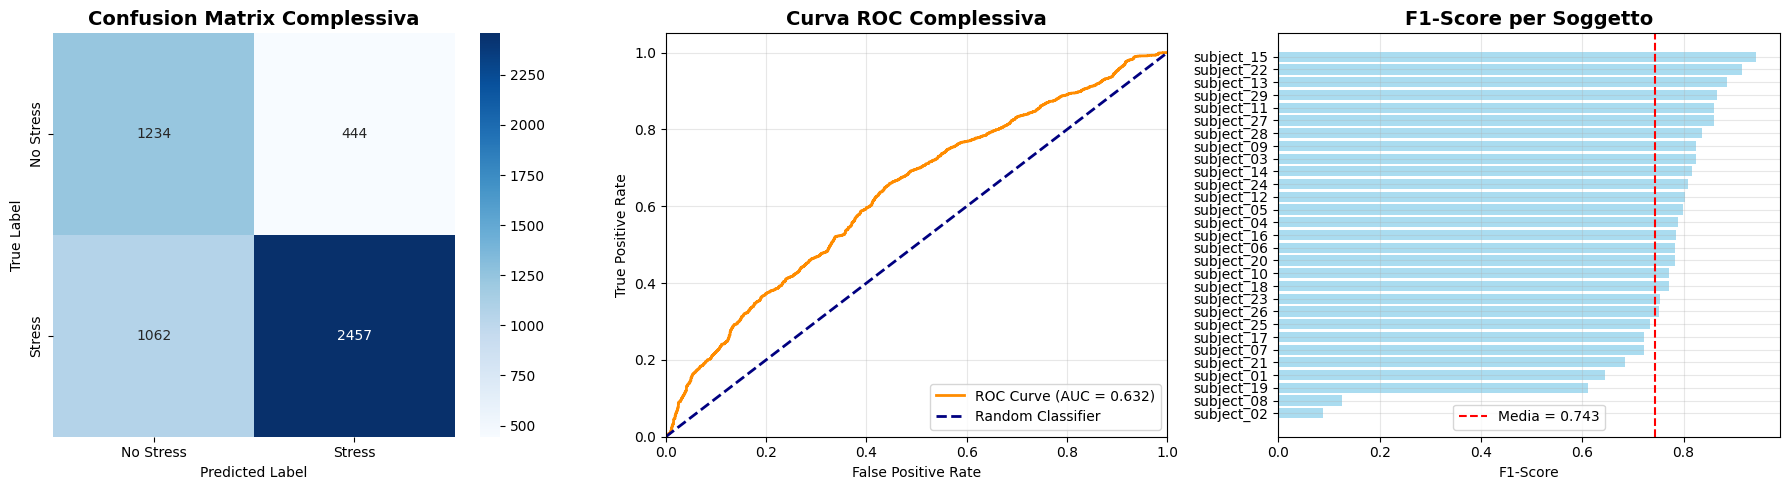


--------------------------------------------------
STATISTICHE FINALI
--------------------------------------------------
Risultati per soggetto:
   subject  n_samples  accuracy  precision  recall  f1_score
subject_01        204    0.5637     0.7714  0.5548    0.6454
subject_02        189    0.3386     1.0000  0.0458    0.0876
subject_03        166    0.7590     0.7833  0.8704    0.8246
subject_04        167    0.7305     0.8077  0.7706    0.7887
subject_05        166    0.7470     0.8300  0.7685    0.7981
subject_06        172    0.6919     0.7328  0.8421    0.7837
subject_07        172    0.6802     0.8554  0.6228    0.7208
subject_08        177    0.3729     1.0000  0.0672    0.1260
subject_09        177    0.7966     0.9770  0.7143    0.8252
subject_10        176    0.6875     0.7561  0.7881    0.7718
subject_11        168    0.8333     0.9556  0.7818    0.8600
subject_12        178    0.7022     0.7248  0.9000    0.8030
subject_13        175    0.8343     0.8296  0.9492    0.8854


In [ ]:
# =============================================================================
# CICLO LOSO COMPLETO CON RECUPERO DATI GLOBALI E SALVATAGGIO PERSISTENTE
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                           auc, accuracy_score, precision_score, recall_score, f1_score)
import numpy as np
import pandas as pd
import warnings
import pickle
import json
warnings.filterwarnings('ignore')

# === SETUP PATH ===
save_dir = "/content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL"
os.makedirs(save_dir, exist_ok=True)
results_file = os.path.join(save_dir, "loso_results.csv")
global_data_file = os.path.join(save_dir, "loso_global_data.pkl")  # File per dati globali
fold_details_file = os.path.join(save_dir, "loso_fold_details.pkl")  # File per dettagli fold

best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/CAMPANELLA"
os.makedirs(best_model_dir, exist_ok=True)

# === FUNZIONE PER SALVARE DATI GLOBALI ===
def save_global_data(y_true, y_pred, y_proba, subjects, save_path):
    """Salva i dati globali per il calcolo delle metriche aggregate"""
    global_data = {
        'y_true': np.array(y_true),
        'y_pred': np.array(y_pred),
        'y_proba': np.array(y_proba),
        'subjects': subjects
    }
    with open(save_path, 'wb') as f:
        pickle.dump(global_data, f)
    print(f"Dati globali salvati in: {save_path}")

def load_global_data(save_path):
    """Carica i dati globali salvati"""
    try:
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None

def save_fold_details(fold_results, save_path):
    """Salva i dettagli dei fold"""
    with open(save_path, 'wb') as f:
        pickle.dump(fold_results, f)
    print(f"Dettagli fold salvati in: {save_path}")

def load_fold_details(save_path):
    """Carica i dettagli dei fold"""
    try:
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return []

# === FUNZIONE PER RICOSTRUIRE DATI GLOBALI DA MODELLI SALVATI ===
def reconstruct_global_data_from_models(completed_subjects, save_dir, X_dict, y, groups, segnali):
    """Ricostruisce i dati globali eseguendo predict sui modelli già salvati"""
    print("=== RICOSTRUZIONE DATI GLOBALI DA MODELLI SALVATI ===")

    all_y_true = []
    all_y_pred = []
    all_y_proba = []
    all_subjects = []

    for subject in completed_subjects:
        print(f"Ricostruendo dati per soggetto: {subject}")

        # Trova il modello salvato per questo soggetto
        model_pattern = os.path.join(save_dir, f"best_model_fold*_{subject}.h5")
        import glob
        model_files = glob.glob(model_pattern)

        if not model_files:
            print(f"  [WARNING] Modello non trovato per {subject}")
            continue

        model_path = model_files[0]

        try:
            # Trova i dati di test per questo soggetto
            subject_indices = np.where(groups == subject)[0]

            if len(subject_indices) == 0:
                print(f"  [WARNING] Nessun dato trovato per {subject}")
                continue

            # Prepara i dati di test
            test_inputs = []
            for seg in segnali:
                X_seg = X_dict[seg]
                X_test_seg = X_seg[subject_indices]

                N_test, T = X_test_seg.shape[:2]
                X_test_flat = X_test_seg.reshape(N_test, T)

                # Usa scaler semplice (idealmente dovremmo salvare anche gli scaler)
                from sklearn.preprocessing import MinMaxScaler
                scaler = MinMaxScaler()
                X_test_scaled = scaler.fit_transform(X_test_flat)
                test_inputs.append(X_test_scaled[..., np.newaxis])

            y_test = y[subject_indices]

            # Carica e usa il modello
            model = build_cnn_model(input_shape=(2880, 1), n_signals=len(segnali))
            model.load_weights(model_path)

            # Predizione
            y_pred_proba = model.predict(test_inputs, verbose=0)
            if len(y_pred_proba.shape) > 1:
                y_pred_proba = y_pred_proba.flatten()

            # Usa soglia 0.5 come default (idealmente dovremmo salvare anche le soglie)
            y_pred = (y_pred_proba > 0.5).astype(int)

            # Accumula dati
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)
            all_y_proba.extend(y_pred_proba)
            all_subjects.extend([subject] * len(y_test))

            print(f"  ✓ Ricostruiti {len(y_test)} campioni per {subject}")

        except Exception as e:
            print(f"  [ERROR] Errore nella ricostruzione per {subject}: {e}")
            continue

    return all_y_true, all_y_pred, all_y_proba, all_subjects

# === CARICA PROGRESSI SE ESISTENTI ===
if os.path.exists(results_file):
    results_df = pd.read_csv(results_file)
    completed_subjects = set(results_df['subject'])
    print(f"Trovati risultati esistenti per {len(completed_subjects)} soggetti: {completed_subjects}")
else:
    results_df = pd.DataFrame()
    completed_subjects = set()

# Carica dati globali esistenti
global_data_existing = load_global_data(global_data_file)
fold_results_existing = load_fold_details(fold_details_file)

# === INIZIALIZZAZIONE VARIABILI PER RACCOLTA METRICHE ===
reports = []
best_f1_score = 0
best_model_info = None

# VARIABILI PER METRICHE AGGREGATE
if global_data_existing is not None:
    print("Caricando dati globali esistenti...")
    all_y_true_global = list(global_data_existing['y_true'])
    all_y_pred_global = list(global_data_existing['y_pred'])
    all_y_proba_global = list(global_data_existing['y_proba'])
    all_subjects_global = list(global_data_existing['subjects'])
    print(f"Caricati {len(all_y_true_global)} campioni da esecuzioni precedenti")
else:
    # Se non esistono dati globali ma ci sono soggetti completati, prova a ricostruire
    if completed_subjects:
        print("Tentativo di ricostruzione dati globali da modelli esistenti...")
        all_y_true_global, all_y_pred_global, all_y_proba_global, all_subjects_global = \
            reconstruct_global_data_from_models(completed_subjects, save_dir, X_dict, y, groups, segnali)
    else:
        all_y_true_global = []
        all_y_pred_global = []
        all_y_proba_global = []
        all_subjects_global = []

# Carica dettagli fold esistenti
if fold_results_existing:
    fold_results = fold_results_existing
    print(f"Caricati dettagli per {len(fold_results)} fold esistenti")
else:
    fold_results = []

print("=== INIZIO CICLO LOSO CON RACCOLTA METRICHE ===")

# === CICLO LOSO PRINCIPALE ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]

    if subject_name in completed_subjects:
        print(f"== Fold {fold+1} - {subject_name} già completato, salto ==")
        continue

    print(f"\n{'='*50}")
    print(f"FOLD {fold+1} - SOGGETTO: {subject_name}")
    print(f"{'='*50}")

    # === PREPARAZIONE DATI ===
    train_inputs = []
    test_inputs = []
    scalers = []

    for seg in segnali:
        X_seg = X_dict[seg]
        X_train_seg = X_seg[train_idx]
        X_test_seg = X_seg[test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train_flat)
        X_test_scaled = scaler.transform(X_test_flat)

        scalers.append(scaler)
        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train = y[train_idx]
    y_test = y[test_idx]

    # === VERIFICA BILANCIAMENTO ===
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)

    print(f"Train distribution: {dict(zip(unique_train, counts_train))}")
    print(f"Test distribution: {dict(zip(unique_test, counts_test))}")

    # Skip se il test set ha una sola classe
    if len(unique_test) < 2:
        print(f"[SKIP] Test set ha una sola classe per {subject_name}")
        continue

    # === CALCOLA CLASS WEIGHTS ===
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))
    print(f"Class weights: {class_weight_dict}")

    # === COSTRUISCI E COMPILA MODELLO ===
    model = build_cnn_model(input_shape=(2880, 1), n_signals=len(segnali))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy']
    )

    # === CALLBACKS ===
    early_stopper = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )

    checkpoint_path = os.path.join(save_dir, f"best_model_fold{fold+1}_{subject_name}.h5")
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # === ADDESTRAMENTO ===
    print("Inizio training...")
    try:
        history = model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=50,
            batch_size=16,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler, checkpoint],
            verbose=1
        )
    except Exception as e:
        print(f"[ERROR] Training fallito per {subject_name}: {e}")
        continue

    # === CARICA MIGLIOR MODELLO ===
    try:
        model.load_weights(checkpoint_path)
    except Exception as e:
        print(f"[ERROR] Impossibile caricare weights per {subject_name}: {e}")
        continue

    # === PREDIZIONE ===
    print("Predizione e valutazione...")
    try:
        y_pred_proba = model.predict(test_inputs, verbose=0)

        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Trova soglia ottimale
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

    except Exception as e:
        print(f"[ERROR] Predizione fallita per {subject_name}: {e}")
        continue

    # === CALCOLO METRICHE INDIVIDUALI ===
    try:
        acc = float(accuracy_score(y_test, y_pred))
        prec = float(precision_score(y_test, y_pred, zero_division=0))
        rec = float(recall_score(y_test, y_pred, zero_division=0))
        f1 = float(f1_score(y_test, y_pred, zero_division=0))
        optimal_threshold = float(optimal_threshold)

    except Exception as e:
        print(f"[ERROR] Calcolo metriche fallito per {subject_name}: {e}")
        continue

    # === STAMPA RISULTATI INDIVIDUALI ===
    print(f"\n--- RISULTATI FOLD {fold+1} - {subject_name} ---")
    print(f"Soglia ottimale: {optimal_threshold:.3f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # === CLASSIFICATION REPORT PER SOGGETTO ===
    print(f"\n--- CLASSIFICATION REPORT - {subject_name} ---")
    try:
        print(classification_report(y_test, y_pred, zero_division=0,
                                  target_names=['No Stress', 'Stress']))

        print(f"\n--- CONFUSION MATRIX - {subject_name} ---")
        cm_individual = confusion_matrix(y_test, y_pred)
        print(cm_individual)

    except Exception as e:
        print(f"[WARNING] Report dettagliato fallito: {e}")

    # === ACCUMULA DATI PER METRICHE GLOBALI ===
    all_y_true_global.extend(y_test)
    all_y_pred_global.extend(y_pred)
    all_y_proba_global.extend(y_pred_proba)
    all_subjects_global.extend([subject_name] * len(y_test))

    # === SALVA DETTAGLI FOLD ===
    fold_results.append({
        'fold': fold + 1,
        'subject': subject_name,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'optimal_threshold': optimal_threshold,
        'class_0_count': int(np.sum(y_test == 0)),
        'class_1_count': int(np.sum(y_test == 1))
    })

    # === VERIFICA MIGLIOR MODELLO ===
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_info = {
            'fold': int(fold + 1),
            'subject': str(subject_name),
            'f1_score': float(f1),
            'accuracy': float(acc),
            'precision': float(prec),
            'recall': float(rec),
            'optimal_threshold': float(optimal_threshold),
            'model_path': str(checkpoint_path),
            'scalers': scalers.copy()
        }
        print(f"*** NUOVO MIGLIOR MODELLO: F1={f1:.4f} ***")

    # === SALVA RISULTATI ===
    result_row = {
        'subject': str(subject_name),
        'accuracy': float(acc),
        'precision': float(prec),
        'recall': float(rec),
        'f1_score': float(f1),
        'optimal_threshold': float(optimal_threshold)
    }

    reports.append(result_row)

    try:
        pd.DataFrame([result_row]).to_csv(
            results_file,
            mode='a',
            index=False,
            header=not os.path.exists(results_file)
        )
        print(f"Risultati salvati per {subject_name}")
    except Exception as e:
        print(f"[WARNING] Salvataggio CSV fallito per {subject_name}: {e}")

    # === SALVA DATI GLOBALI INCREMENTALMENTE ===
    save_global_data(all_y_true_global, all_y_pred_global, all_y_proba_global,
                     all_subjects_global, global_data_file)
    save_fold_details(fold_results, fold_details_file)

    # === PULIZIA MEMORIA ===
    try:
        del model, history, y_pred_proba, y_pred
        tf.keras.backend.clear_session()
    except:
        pass

# === CARICA TUTTI I RISULTATI FINALI ===
print(f"\n{'='*70}")
print("CARICAMENTO RISULTATI COMPLETI")
print(f"{'='*70}")

# Ricarica tutti i risultati dal CSV
if os.path.exists(results_file):
    all_results_df = pd.read_csv(results_file)
    print(f"Caricati risultati per {len(all_results_df)} soggetti totali")
else:
    all_results_df = pd.DataFrame()

# Ricarica dati globali finali
final_global_data = load_global_data(global_data_file)
final_fold_details = load_fold_details(fold_details_file)

if final_global_data is not None:
    all_y_true_global = final_global_data['y_true']
    all_y_pred_global = final_global_data['y_pred']
    all_y_proba_global = final_global_data['y_proba']
    all_subjects_global = final_global_data['subjects']
    fold_results = final_fold_details if final_fold_details else fold_results

# === SALVA MIGLIOR MODELLO ===
if best_model_info is not None:
    print(f"\n=== SALVATAGGIO MIGLIOR MODELLO ===")
    print(f"Miglior F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

    try:
        best_model = build_cnn_model(input_shape=(2880, 1), n_signals=len(segnali))
        best_model.load_weights(best_model_info['model_path'])

        best_model_path = os.path.join(best_model_dir, "best_model.keras")
        best_model.save(best_model_path)

        import joblib
        scalers_path = os.path.join(best_model_dir, "scalers.pkl")
        joblib.dump(best_model_info['scalers'], scalers_path)

        best_info_path = os.path.join(best_model_dir, "best_model_info.json")

        model_info = {
            'fold': best_model_info['fold'],
            'subject': best_model_info['subject'],
            'f1_score': best_model_info['f1_score'],
            'accuracy': best_model_info['accuracy'],
            'precision': best_model_info['precision'],
            'recall': best_model_info['recall'],
            'optimal_threshold': best_model_info['optimal_threshold']
        }

        with open(best_info_path, 'w') as f:
            json.dump(model_info, f, indent=2)

        print(f"Miglior modello salvato in: {best_model_path}")
        print(f"Scaler salvati in: {scalers_path}")
        print(f"Informazioni salvate in: {best_info_path}")

    except Exception as e:
        print(f"[ERROR] Salvataggio miglior modello fallito: {e}")

# =============================================================================
# VISUALIZZAZIONE METRICHE AGGREGATE COMPLETE
# =============================================================================

print(f"\n{'='*70}")
print("VALUTAZIONE COMPLESSIVA CICLO LOSO - TUTTI I SOGGETTI")
print(f"{'='*70}")

print(f"Campioni totali raccolti: {len(all_y_true_global)}")
print(f"Soggetti processati: {len(fold_results) if fold_results else 0}")
if len(all_y_true_global) > 0:
    print(f"Distribuzione classi globale: No Stress={np.sum(all_y_true_global == 0)}, Stress={np.sum(all_y_true_global == 1)}")

# === 1. CLASSIFICATION REPORT COMPLESSIVO ===
print(f"\n{'-'*50}")
print("CLASSIFICATION REPORT COMPLESSIVO")
print(f"{'-'*50}")

if len(all_y_true_global) > 0:
    global_report = classification_report(
        all_y_true_global, all_y_pred_global,
        zero_division=0,
        target_names=['No Stress', 'Stress']
    )
    print(global_report)

    # === 2. CONFUSION MATRIX COMPLESSIVA ===
    print(f"\n{'-'*50}")
    print("CONFUSION MATRIX COMPLESSIVA")
    print(f"{'-'*50}")

    cm_global = confusion_matrix(all_y_true_global, all_y_pred_global)
    print("Confusion Matrix (Counts):")
    print(cm_global)

    # Percentuali
    cm_percent = cm_global.astype('float') / cm_global.sum(axis=1)[:, np.newaxis] * 100
    print("\nConfusion Matrix (Percentages):")
    print(f"[[{cm_percent[0,0]:.1f}% {cm_percent[0,1]:.1f}%]")
    print(f" [{cm_percent[1,0]:.1f}% {cm_percent[1,1]:.1f}%]]")

    # Visualizzazione grafica
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Confusion Matrix
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0])
    axes[0].set_title('Confusion Matrix Complessiva', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # === 3. CURVA ROC COMPLESSIVA ===
    fpr, tpr, _ = roc_curve(all_y_true_global, all_y_proba_global)
    roc_auc = auc(fpr, tpr)

    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Complessiva', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    print(f"\n{'-'*50}")
    print("CURVA ROC COMPLESSIVA")
    print(f"{'-'*50}")
    print(f"AUC (Area Under Curve): {roc_auc:.4f}")

    # === 4. PERFORMANCE PER SOGGETTO ===
    if fold_results:
        fold_df = pd.DataFrame(fold_results)
        fold_df_sorted = fold_df.sort_values('f1_score', ascending=True)

        axes[2].barh(fold_df_sorted['subject'], fold_df_sorted['f1_score'],
                     color='skyblue', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3)

        # Aggiungi linea media
        mean_f1 = fold_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--',
                        label=f'Media = {mean_f1:.3f}')
        axes[2].legend()

    plt.tight_layout()
    plt.show()

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

# === STATISTICHE FINALI ===
print(f"\n{'-'*50}")
print("STATISTICHE FINALI")
print(f"{'-'*50}")

if fold_results:
    fold_df = pd.DataFrame(fold_results)

    print("Risultati per soggetto:")
    print(fold_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(index=False, float_format='%.4f'))

    print(f"\nStatistiche aggregate:")
    print(f"F1-Score medio: {fold_df['f1_score'].mean():.4f} ± {fold_df['f1_score'].std():.4f}")
    print(f"Accuracy media: {fold_df['accuracy'].mean():.4f} ± {fold_df['accuracy'].std():.4f}")
    print(f"Precision media: {fold_df['precision'].mean():.4f} ± {fold_df['precision'].std():.4f}")
    print(f"Recall medio: {fold_df['recall'].mean():.4f} ± {fold_df['recall'].std():.4f}")

    print(f"\nRange performance:")
    print(f"F1-Score: {fold_df['f1_score'].min():.4f} - {fold_df['f1_score'].max():.4f}")
    print(f"Miglior soggetto: {fold_df.loc[fold_df['f1_score'].idxmax(), 'subject']} (F1={fold_df['f1_score'].max():.4f})")
    print(f"Peggiore soggetto: {fold_df.loc[fold_df['f1_score'].idxmin(), 'subject']} (F1={fold_df['f1_score'].min():.4f})")

print(f"\n{'='*70}")
print("CICLO LOSO COMPLETATO!")
print(f"{'='*70}")